<a href="https://colab.research.google.com/github/Youssef-Ghallab/Facial-Recognition/blob/main/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install opencv-python
!pip install torch torchvision torchaudio
!pip install pandas
!pip install numpy

In [ ]:
from PIL import Image
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision

from google.colab import files
#files.upload()

# Create the .kaggle directory and move the kaggle.json file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hereisburak/pins-face-recognition



KeyboardInterrupt: 

#First we crop the faces and create a new dataset

In [ ]:
# Extract the downloaded dataset
with zipfile.ZipFile('/content/pins-face-recognition.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/pins_faces')

In [ ]:
#load the pins dataset
from PIL import Image
X = []
y = []
dir = r"/content/pins_faces/105_classes_pins_dataset"
for i in os.listdir(dir):
    for j in os.listdir(dir+"/"+i):
        img = Image.open(dir+"/"+i+"/"+j)
        img = img.resize((128, 128))
        X.append(np.asarray(img))
        y.append(i)
X = np.asarray(X)
y = np.asarray(y)
# Normalize pixel values
X = X.astype('float32') / 255.0


Image index: 10977
Label: Tom Hardy


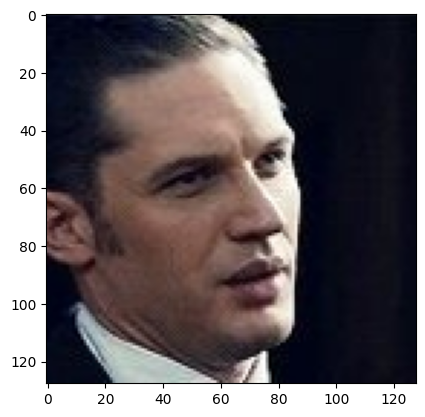

Image index: 4436
Label: camila mendes


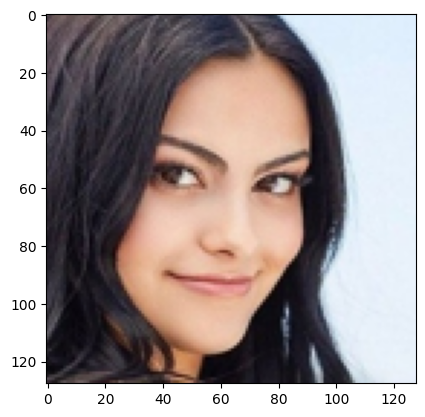

Image index: 5081
Label: Robert De Niro


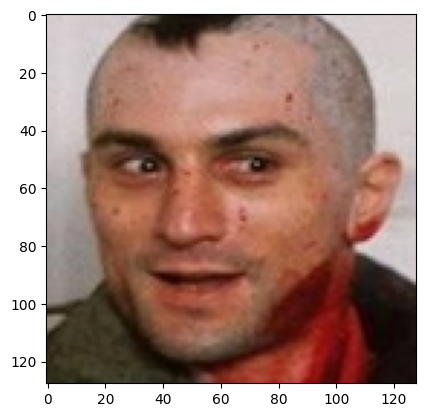

Image index: 4033
Label: Alex Lawther


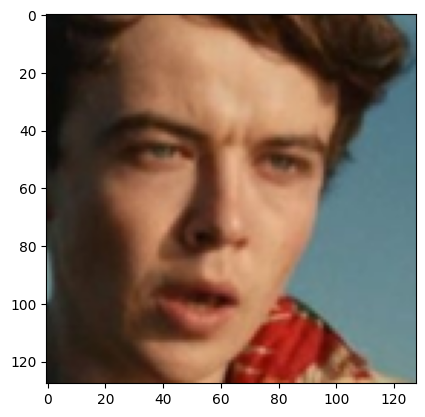

Image index: 992
Label: Lionel Messi


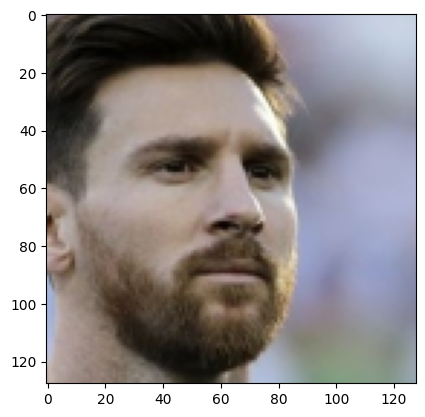

In [ ]:
import random
y = [label[5:] for label in y]
# Show 5 random pairs of x and y
for i in range(5):
  random_index = random.randint(0, len(X) - 1)
  print(f"Image index: {random_index}")
  print(f"Label: {y[random_index]}")
  # You can display the image using matplotlib or another library
  # For example, with matplotlib:
  import matplotlib.pyplot as plt
  plt.imshow(X[random_index])
  plt.show()

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm

# Load the Haar cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect and crop the most likely face while keeping the original order
def detect_and_crop_faces(images):
    cropped_faces = []

    for img in tqdm(images, desc="Detecting and cropping faces"):
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  # Normalize and convert to uint8 if necessary

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        # Check if any faces were detected
        if len(faces) > 0:
            # Select the largest detected face
            x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])  # Find the face with the largest area
            cropped_faces.append(img[y:y+h, x:x+w])
        else:
            cropped_faces.append(img) # if no face detected, return the original image, this works because the dataset originally shows faces of celebrities

    return cropped_faces

cropped_faces = detect_and_crop_faces(X)


Detecting and cropping faces: 100%|██████████| 17534/17534 [03:12<00:00, 91.26it/s]


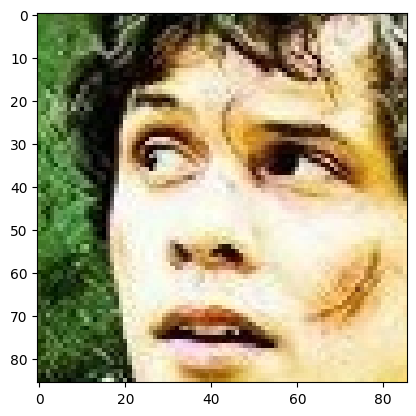

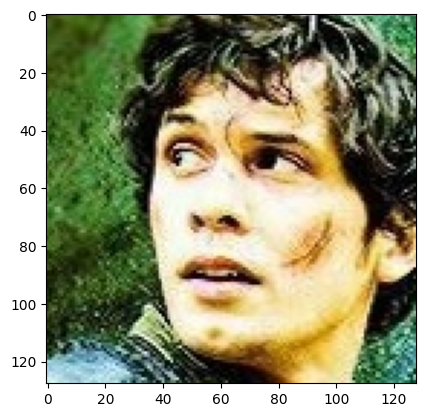

In [ ]:
plt.imshow(cropped_faces[0])
plt.show()
plt.imshow(X[0])
plt.show()

We will show 5 pictures before and after cropping to ensure consistency

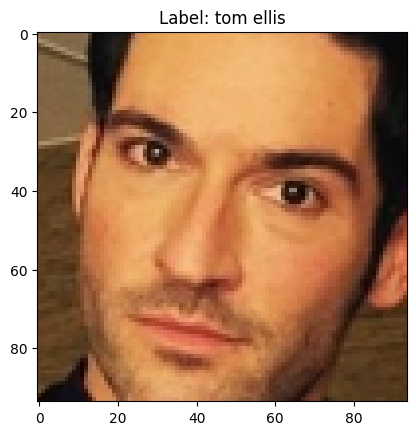

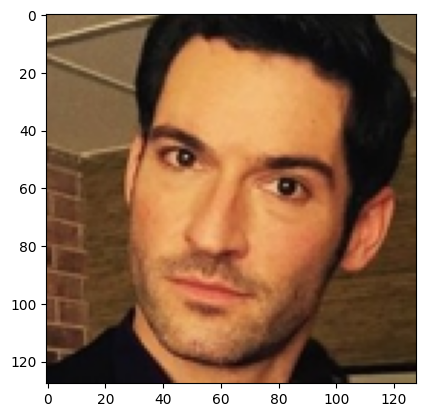

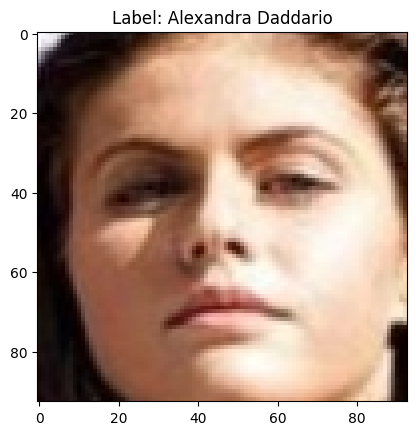

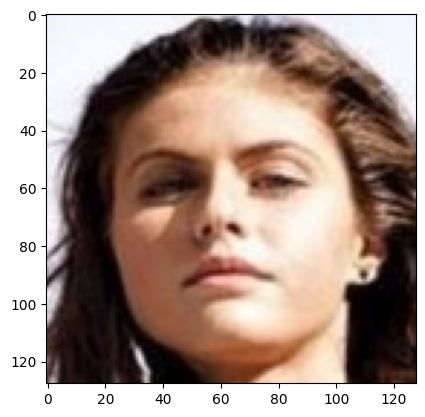

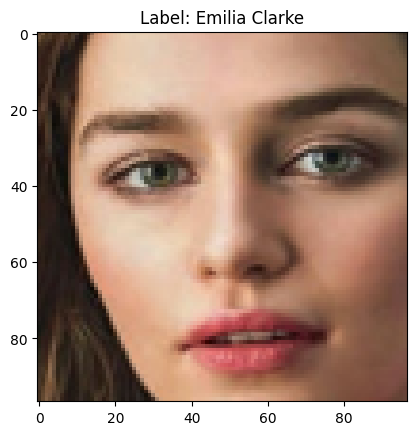

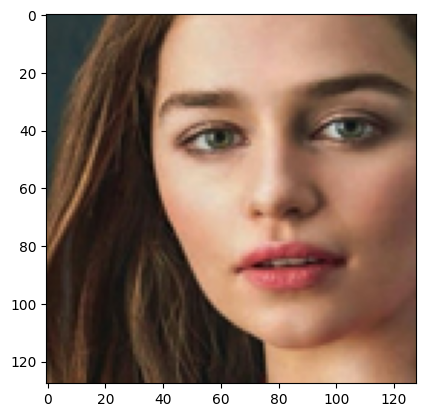

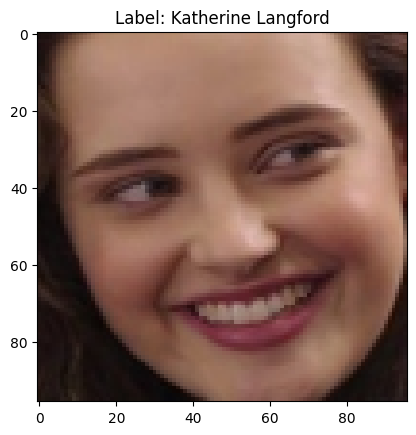

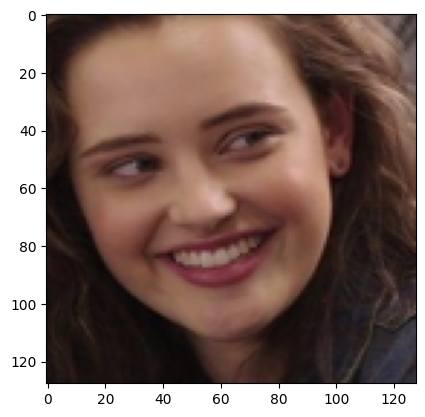

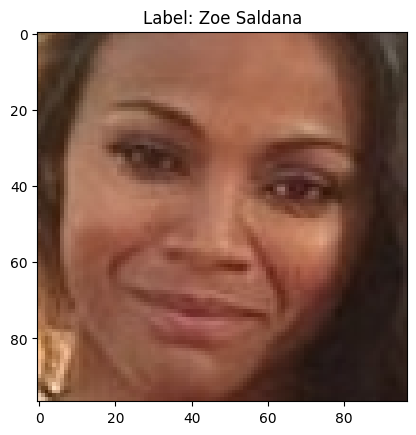

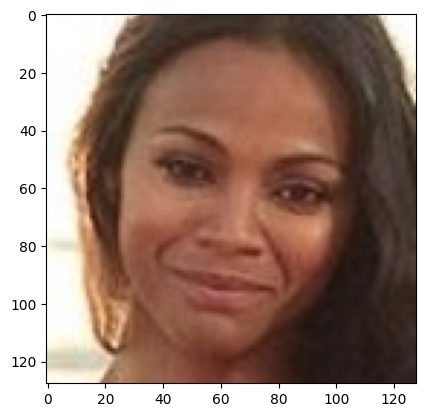

In [ ]:
# prompt: show 5 random cropped faces and the labels

import matplotlib.pyplot as plt
import random

# Assuming 'cropped_faces' and 'y' are defined from the previous code

# Show 5 random cropped faces and their labels
for _ in range(5):
    random_index = random.randint(0, len(cropped_faces) - 1)
    plt.imshow((cropped_faces[random_index]))
    plt.title(f"Label: {y[random_index]}")
    plt.show()
    plt.imshow(X[random_index])
    plt.show()

Now we save the New dataset to drive

In [ ]:
import os
import cv2

# Create the output directory if it doesn't exist
output_dir = "/content/drive/MyDrive/cropped_faces_dataset1"
os.makedirs(output_dir, exist_ok=True)

# Iterate through the cropped faces and their corresponding labels
for i, cropped_face in tqdm(enumerate(cropped_faces), desc="Saving cropped faces", total=len(cropped_faces)):
    label = y[i]

    # Only proceed if there is a valid cropped face
    if cropped_face is not None:
        # Convert BGR to RGB
        cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

        # Create a subfolder for the label if it doesn't exist
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # Save the cropped face image to the label's subfolder
        image_filename = os.path.join(label_dir, f"cropped_face_{i}.jpg")
        cv2.imwrite(image_filename, cropped_face_rgb)


Saving cropped faces: 100%|██████████| 17534/17534 [03:23<00:00, 86.31it/s]


#Feature Extraction

First we Load the data from drive


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tqdm.notebook import tqdm  # For the progress bar

# Directory containing cropped images
output_dir = "/content/drive/MyDrive/cropped_faces_dataset1"

# Set image size
image_size = (224, 224)

# Load images and labels
images = []
labels = []

# Iterate through the dataset
for label in tqdm(os.listdir(output_dir), desc="Loading Labels", unit="label"):
    label_dir = os.path.join(output_dir, label)
    for img_file in tqdm(os.listdir(label_dir), desc=f"Loading {label}", unit="image", leave=False):
        img_path = os.path.join(label_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # Read image as RGB
        img = cv2.resize(img, image_size)  # Resize to 128x128
        images.append(img)
        labels.append(label)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Normalize pixel values (scaling them between 0 and 1)
X = X.astype('float32') / 255.0

# Encode labels and apply one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

# Split data (70% train, 15% validation, 15% test) with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y_one_hot, test_size=0.3, stratify=y_one_hot, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Reshape X to add the channel dimension (RGB, so 3 channels)
X_train = X_train.reshape(X_train.shape[0], image_size[0], image_size[1], 3)
X_val = X_val.reshape(X_val.shape[0], image_size[0], image_size[1], 3)
X_test = X_test.reshape(X_test.shape[0], image_size[0], image_size[1], 3)

print("Data loading complete.")


Loading Labels:   0%|          | 0/105 [00:00<?, ?label/s]

Loading Bobby Morley:   0%|          | 0/138 [00:00<?, ?image/s]

Loading Lindsey Morgan:   0%|          | 0/169 [00:00<?, ?image/s]

Loading Wentworth Miller:   0%|          | 0/179 [00:00<?, ?image/s]

Loading Lili Reinhart:   0%|          | 0/150 [00:00<?, ?image/s]

Loading Jennifer Lawrence:   0%|          | 0/180 [00:00<?, ?image/s]

Loading Sarah Wayne Callies:   0%|          | 0/159 [00:00<?, ?image/s]

Loading Lionel Messi:   0%|          | 0/86 [00:00<?, ?image/s]

Loading Avril Lavigne:   0%|          | 0/162 [00:00<?, ?image/s]

Loading Ben Affleck:   0%|          | 0/126 [00:00<?, ?image/s]

Loading Eliza Taylor:   0%|          | 0/162 [00:00<?, ?image/s]

Loading Ursula Corbero:   0%|          | 0/167 [00:00<?, ?image/s]

Loading Emilia Clarke:   0%|          | 0/210 [00:00<?, ?image/s]

Loading Hugh Jackman:   0%|          | 0/179 [00:00<?, ?image/s]

Loading Chris Hemsworth:   0%|          | 0/159 [00:00<?, ?image/s]

Loading Inbar Lavi:   0%|          | 0/127 [00:00<?, ?image/s]

Loading Zendaya:   0%|          | 0/138 [00:00<?, ?image/s]

Loading Selena Gomez:   0%|          | 0/186 [00:00<?, ?image/s]

Loading Danielle Panabaker:   0%|          | 0/181 [00:00<?, ?image/s]

Loading Natalie Portman:   0%|          | 0/166 [00:00<?, ?image/s]

Loading Logan Lerman:   0%|          | 0/212 [00:00<?, ?image/s]

Loading Sophie Turner:   0%|          | 0/204 [00:00<?, ?image/s]

Loading jeff bezos:   0%|          | 0/106 [00:00<?, ?image/s]

Loading Jimmy Fallon:   0%|          | 0/113 [00:00<?, ?image/s]

Loading kiernen shipka:   0%|          | 0/203 [00:00<?, ?image/s]

Loading Krysten Ritter:   0%|          | 0/171 [00:00<?, ?image/s]

Loading Alex Lawther:   0%|          | 0/152 [00:00<?, ?image/s]

Loading amber heard:   0%|          | 0/218 [00:00<?, ?image/s]

Loading camila mendes:   0%|          | 0/162 [00:00<?, ?image/s]

Loading Zac Efron:   0%|          | 0/191 [00:00<?, ?image/s]

Loading gal gadot:   0%|          | 0/199 [00:00<?, ?image/s]

Loading Robert De Niro:   0%|          | 0/156 [00:00<?, ?image/s]

Loading ellen page:   0%|          | 0/188 [00:00<?, ?image/s]

Loading margot robbie:   0%|          | 0/221 [00:00<?, ?image/s]

Loading Rami Malek:   0%|          | 0/160 [00:00<?, ?image/s]

Loading Bill Gates:   0%|          | 0/122 [00:00<?, ?image/s]

Loading Cristiano Ronaldo:   0%|          | 0/98 [00:00<?, ?image/s]

Loading Robert Downey Jr:   0%|          | 0/233 [00:00<?, ?image/s]

Loading Henry Cavil:   0%|          | 0/195 [00:00<?, ?image/s]

Loading Irina Shayk:   0%|          | 0/156 [00:00<?, ?image/s]

Loading Jason Momoa:   0%|          | 0/184 [00:00<?, ?image/s]

Loading Neil Patrick Harris:   0%|          | 0/116 [00:00<?, ?image/s]

Loading Stephen Amell:   0%|          | 0/159 [00:00<?, ?image/s]

Loading elon musk:   0%|          | 0/135 [00:00<?, ?image/s]

Loading Amanda Crew:   0%|          | 0/117 [00:00<?, ?image/s]

Loading Adriana Lima:   0%|          | 0/213 [00:00<?, ?image/s]

Loading Emma Watson:   0%|          | 0/211 [00:00<?, ?image/s]

Loading Dwayne Johnson:   0%|          | 0/141 [00:00<?, ?image/s]

Loading Rebecca Ferguson:   0%|          | 0/178 [00:00<?, ?image/s]

Loading melissa fumero:   0%|          | 0/154 [00:00<?, ?image/s]

Loading Jeremy Renner:   0%|          | 0/167 [00:00<?, ?image/s]

Loading Anthony Mackie:   0%|          | 0/124 [00:00<?, ?image/s]

Loading Anne Hathaway:   0%|          | 0/203 [00:00<?, ?image/s]

Loading Tom Holland:   0%|          | 0/189 [00:00<?, ?image/s]

Loading scarlett johansson:   0%|          | 0/201 [00:00<?, ?image/s]

Loading Mark Ruffalo:   0%|          | 0/178 [00:00<?, ?image/s]

Loading Marie Avgeropoulos:   0%|          | 0/161 [00:00<?, ?image/s]

Loading Nadia Hilker:   0%|          | 0/133 [00:00<?, ?image/s]

Loading Leonardo DiCaprio:   0%|          | 0/237 [00:00<?, ?image/s]

Loading Katharine Mcphee:   0%|          | 0/177 [00:00<?, ?image/s]

Loading alycia dabnem carey:   0%|          | 0/211 [00:00<?, ?image/s]

Loading Zoe Saldana:   0%|          | 0/186 [00:00<?, ?image/s]

Loading Emma Stone:   0%|          | 0/139 [00:00<?, ?image/s]

Loading Tuppence Middleton:   0%|          | 0/133 [00:00<?, ?image/s]

Loading Tom Cruise:   0%|          | 0/192 [00:00<?, ?image/s]

Loading Miley Cyrus:   0%|          | 0/178 [00:00<?, ?image/s]

Loading Tom Hardy:   0%|          | 0/198 [00:00<?, ?image/s]

Loading Rihanna:   0%|          | 0/133 [00:00<?, ?image/s]

Loading Morena Baccarin:   0%|          | 0/175 [00:00<?, ?image/s]

Loading Christian Bale:   0%|          | 0/154 [00:00<?, ?image/s]

Loading Elizabeth Lail:   0%|          | 0/158 [00:00<?, ?image/s]

Loading Taylor Swift:   0%|          | 0/131 [00:00<?, ?image/s]

Loading Richard Harmon:   0%|          | 0/148 [00:00<?, ?image/s]

Loading Pedro Alonso:   0%|          | 0/125 [00:00<?, ?image/s]

Loading Gwyneth Paltrow:   0%|          | 0/187 [00:00<?, ?image/s]

Loading Brie Larson:   0%|          | 0/169 [00:00<?, ?image/s]

Loading barbara palvin:   0%|          | 0/197 [00:00<?, ?image/s]

Loading barack obama:   0%|          | 0/119 [00:00<?, ?image/s]

Loading elizabeth olsen:   0%|          | 0/221 [00:00<?, ?image/s]

Loading Morgan Freeman:   0%|          | 0/105 [00:00<?, ?image/s]

Loading Megan Fox:   0%|          | 0/209 [00:00<?, ?image/s]

Loading Penn Badgley:   0%|          | 0/171 [00:00<?, ?image/s]

Loading Maria Pedraza:   0%|          | 0/122 [00:00<?, ?image/s]

Loading Jessica Barden:   0%|          | 0/141 [00:00<?, ?image/s]

Loading Brenton Thwaites:   0%|          | 0/209 [00:00<?, ?image/s]

Loading Tom Hiddleston:   0%|          | 0/181 [00:00<?, ?image/s]

Loading Jake Mcdorman:   0%|          | 0/159 [00:00<?, ?image/s]

Loading Millie Bobby Brown:   0%|          | 0/191 [00:00<?, ?image/s]

Loading grant gustin:   0%|          | 0/183 [00:00<?, ?image/s]

Loading tom ellis:   0%|          | 0/180 [00:00<?, ?image/s]

Loading Maisie Williams:   0%|          | 0/193 [00:00<?, ?image/s]

Loading Josh Radnor:   0%|          | 0/117 [00:00<?, ?image/s]

Loading Alexandra Daddario:   0%|          | 0/225 [00:00<?, ?image/s]

Loading Natalie Dormer:   0%|          | 0/198 [00:00<?, ?image/s]

Loading Katherine Langford:   0%|          | 0/226 [00:00<?, ?image/s]

Loading Andy Samberg:   0%|          | 0/196 [00:00<?, ?image/s]

Loading Madelaine Petsch:   0%|          | 0/192 [00:00<?, ?image/s]

Loading Chris Evans:   0%|          | 0/166 [00:00<?, ?image/s]

Loading Chris Pratt:   0%|          | 0/176 [00:00<?, ?image/s]

Loading Shakira Isabel Mebarak:   0%|          | 0/154 [00:00<?, ?image/s]

Loading Dominic Purcell:   0%|          | 0/146 [00:00<?, ?image/s]

Loading Alvaro Morte:   0%|          | 0/139 [00:00<?, ?image/s]

Loading Mark Zuckerberg:   0%|          | 0/95 [00:00<?, ?image/s]

Loading Brian J. Smith:   0%|          | 0/102 [00:00<?, ?image/s]

Loading Johnny Depp:   0%|          | 0/182 [00:00<?, ?image/s]

Loading Keanu Reeves:   0%|          | 0/71 [00:00<?, ?image/s]

Data loading complete.


VGGFace Feature extractor will be used for this task

In [7]:
!kaggle datasets download -d acharyarupak391/vggfaceweights

Dataset URL: https://www.kaggle.com/datasets/acharyarupak391/vggfaceweights
License(s): unknown
 99% 514M/521M [00:05<00:00, 78.0MB/s]
100% 521M/521M [00:05<00:00, 104MB/s] 


In [8]:
import zipfile
with zipfile.ZipFile('/content/vggfaceweights.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/vggfaceweights')

In [ ]:
#this implements the VGG architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

Then we inistantize the model and load the pretrained weights

In [ ]:
model = vgg_face()
model.load_weights('/content/vggfaceweights/vgg_face_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


now we delete the binary classification to only get image signature, a (2622,1) vector for each image


In [ ]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [ ]:
vgg_face_descriptor.inputs, vgg_face_descriptor.outputs

([<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=None, name=keras_tensor>],
 [<KerasTensor shape=(None, 2622), dtype=float32, sparse=False, name=keras_tensor_703>])

In [ ]:
img = X[0]
img = (img / 1.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
(2622,)


Now we get the signatures for the cropped dataset

In [ ]:
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
with tf.device('/GPU:0'):
  embeddings = []

  for img in tqdm(X, desc="Processing Images", unit="image"):
      img = cv2.resize(img, dsize=(224, 224))
      img = (img / 255.).astype(np.float32)

      embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
      embeddings.append(embedding_vector)


Processing Images:  94%|█████████▎| 16339/17445 [37:45<02:19,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▎| 16340/17445 [37:45<02:22,  7.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▎| 16341/17445 [37:45<02:13,  8.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▎| 16342/17445 [37:45<02:22,  7.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▎| 16343/17445 [37:45<02:18,  7.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  94%|█████████▎| 16344/17445 [37:46<02:39,  6.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  94%|█████████▎| 16345/17445 [37:46<02:35,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▎| 16346/17445 [37:46<02:40,  6.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  94%|█████████▎| 16347/17445 [37:46<02:41,  6.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  94%|█████████▎| 16348/17445 [37:46<02:57,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  94%|█████████▎| 16349/17445 [37:46<02:42,  6.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▎| 16350/17445 [37:46<02:38,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▎| 16351/17445 [37:47<02:24,  7.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▎| 16352/17445 [37:47<02:27,  7.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  94%|█████████▎| 16353/17445 [37:47<02:33,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▎| 16354/17445 [37:47<02:19,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16355/17445 [37:47<02:24,  7.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16356/17445 [37:47<02:28,  7.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16357/17445 [37:47<02:18,  7.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16358/17445 [37:47<02:21,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  94%|█████████▍| 16359/17445 [37:48<02:32,  7.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16360/17445 [37:48<02:25,  7.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16361/17445 [37:48<02:26,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16362/17445 [37:48<02:27,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  94%|█████████▍| 16363/17445 [37:48<02:29,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  94%|█████████▍| 16364/17445 [37:48<02:31,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16365/17445 [37:48<02:32,  7.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16366/17445 [37:49<02:19,  7.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  94%|█████████▍| 16367/17445 [37:49<02:23,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16368/17445 [37:49<02:24,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16369/17445 [37:49<02:15,  7.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16370/17445 [37:49<02:20,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16371/17445 [37:49<02:23,  7.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16372/17445 [37:49<02:27,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16373/17445 [37:49<02:23,  7.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16374/17445 [37:50<02:13,  8.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16375/17445 [37:50<02:27,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16376/17445 [37:50<02:17,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16377/17445 [37:50<02:19,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16378/17445 [37:50<02:26,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16379/17445 [37:50<02:30,  7.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  94%|█████████▍| 16380/17445 [37:50<02:36,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  94%|█████████▍| 16381/17445 [37:51<02:42,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  94%|█████████▍| 16382/17445 [37:51<02:44,  6.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  94%|█████████▍| 16383/17445 [37:51<02:39,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16384/17445 [37:51<02:35,  6.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16385/17445 [37:51<02:33,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16386/17445 [37:51<02:24,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16387/17445 [37:51<02:31,  6.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  94%|█████████▍| 16388/17445 [37:52<02:18,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  94%|█████████▍| 16389/17445 [37:52<02:12,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16390/17445 [37:52<02:15,  7.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  94%|█████████▍| 16391/17445 [37:52<02:24,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16392/17445 [37:52<02:34,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16393/17445 [37:52<02:23,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16394/17445 [37:52<02:13,  7.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16395/17445 [37:53<02:13,  7.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16396/17445 [37:53<02:16,  7.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16397/17445 [37:53<02:23,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16398/17445 [37:53<02:12,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16399/17445 [37:53<02:04,  8.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  94%|█████████▍| 16401/17445 [37:53<02:02,  8.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  94%|█████████▍| 16402/17445 [37:53<02:05,  8.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16403/17445 [37:54<02:18,  7.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  94%|█████████▍| 16404/17445 [37:54<02:19,  7.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  94%|█████████▍| 16405/17445 [37:54<02:38,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  94%|█████████▍| 16406/17445 [37:54<02:41,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  94%|█████████▍| 16407/17445 [37:54<02:38,  6.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  94%|█████████▍| 16408/17445 [37:54<02:44,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16409/17445 [37:54<02:40,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16410/17445 [37:55<02:43,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  94%|█████████▍| 16411/17445 [37:55<02:47,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16412/17445 [37:55<02:40,  6.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  94%|█████████▍| 16413/17445 [37:55<02:40,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  94%|█████████▍| 16414/17445 [37:55<02:42,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  94%|█████████▍| 16415/17445 [37:55<02:47,  6.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Processing Images:  94%|█████████▍| 16416/17445 [37:56<02:55,  5.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16417/17445 [37:56<02:52,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16418/17445 [37:56<02:44,  6.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  94%|█████████▍| 16419/17445 [37:56<02:45,  6.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  94%|█████████▍| 16420/17445 [37:56<02:40,  6.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16421/17445 [37:56<02:38,  6.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  94%|█████████▍| 16422/17445 [37:57<02:31,  6.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  94%|█████████▍| 16423/17445 [37:57<02:37,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  94%|█████████▍| 16424/17445 [37:57<02:34,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  94%|█████████▍| 16425/17445 [37:57<02:36,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16426/17445 [37:57<02:35,  6.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  94%|█████████▍| 16427/17445 [37:57<02:42,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  94%|█████████▍| 16428/17445 [37:57<02:40,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16429/17445 [37:58<02:38,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16430/17445 [37:58<02:29,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  94%|█████████▍| 16431/17445 [37:58<02:28,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16432/17445 [37:58<02:34,  6.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  94%|█████████▍| 16433/17445 [37:58<02:39,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  94%|█████████▍| 16434/17445 [37:58<02:35,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  94%|█████████▍| 16435/17445 [37:59<02:33,  6.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  94%|█████████▍| 16436/17445 [37:59<02:32,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  94%|█████████▍| 16437/17445 [37:59<02:23,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  94%|█████████▍| 16438/17445 [37:59<02:22,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  94%|█████████▍| 16439/17445 [37:59<02:21,  7.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  94%|█████████▍| 16440/17445 [37:59<02:22,  7.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  94%|█████████▍| 16441/17445 [37:59<02:36,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  94%|█████████▍| 16442/17445 [38:00<02:39,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  94%|█████████▍| 16443/17445 [38:00<02:42,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  94%|█████████▍| 16444/17445 [38:00<02:37,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  94%|█████████▍| 16445/17445 [38:00<02:47,  5.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16446/17445 [38:00<02:35,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  94%|█████████▍| 16448/17445 [38:00<02:16,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  94%|█████████▍| 16449/17445 [38:01<02:24,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16450/17445 [38:01<02:12,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16451/17445 [38:01<02:06,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  94%|█████████▍| 16452/17445 [38:01<02:10,  7.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16453/17445 [38:01<02:07,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  94%|█████████▍| 16454/17445 [38:01<02:12,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16455/17445 [38:01<02:16,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16456/17445 [38:02<02:16,  7.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16457/17445 [38:02<02:19,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16458/17445 [38:02<02:08,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  94%|█████████▍| 16459/17445 [38:02<02:26,  6.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16460/17445 [38:02<02:25,  6.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16461/17445 [38:02<02:24,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16462/17445 [38:02<02:20,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16463/17445 [38:03<02:20,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  94%|█████████▍| 16464/17445 [38:03<02:16,  7.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  94%|█████████▍| 16465/17445 [38:03<02:06,  7.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16466/17445 [38:03<01:58,  8.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  94%|█████████▍| 16467/17445 [38:03<01:53,  8.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  94%|█████████▍| 16468/17445 [38:03<01:49,  8.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16469/17445 [38:03<02:01,  8.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16470/17445 [38:03<01:59,  8.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  94%|█████████▍| 16471/17445 [38:03<01:53,  8.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16472/17445 [38:04<01:58,  8.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  94%|█████████▍| 16473/17445 [38:04<02:11,  7.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16474/17445 [38:04<02:02,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  94%|█████████▍| 16475/17445 [38:04<02:20,  6.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  94%|█████████▍| 16476/17445 [38:04<02:25,  6.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16477/17445 [38:04<02:24,  6.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16478/17445 [38:04<02:13,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  94%|█████████▍| 16479/17445 [38:05<02:12,  7.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  94%|█████████▍| 16480/17445 [38:05<02:24,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  94%|█████████▍| 16481/17445 [38:05<02:10,  7.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  94%|█████████▍| 16483/17445 [38:05<02:01,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  94%|█████████▍| 16484/17445 [38:05<02:03,  7.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  94%|█████████▍| 16485/17445 [38:05<02:11,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  95%|█████████▍| 16487/17445 [38:06<01:57,  8.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16488/17445 [38:06<01:54,  8.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16489/17445 [38:06<01:49,  8.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  95%|█████████▍| 16490/17445 [38:06<01:58,  8.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16491/17445 [38:06<01:55,  8.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16492/17445 [38:06<01:50,  8.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▍| 16493/17445 [38:06<01:50,  8.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  95%|█████████▍| 16494/17445 [38:06<01:57,  8.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▍| 16495/17445 [38:07<02:01,  7.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16496/17445 [38:07<02:08,  7.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16498/17445 [38:07<01:52,  8.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16499/17445 [38:07<01:50,  8.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▍| 16500/17445 [38:07<01:47,  8.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  95%|█████████▍| 16501/17445 [38:07<01:47,  8.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  95%|█████████▍| 16502/17445 [38:07<02:02,  7.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▍| 16503/17445 [38:08<02:07,  7.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▍| 16504/17445 [38:08<02:07,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▍| 16505/17445 [38:08<02:07,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  95%|█████████▍| 16506/17445 [38:08<02:22,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16507/17445 [38:08<02:08,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▍| 16508/17445 [38:08<02:07,  7.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  95%|█████████▍| 16509/17445 [38:08<02:13,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16510/17445 [38:09<02:11,  7.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16511/17445 [38:09<02:19,  6.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16512/17445 [38:09<02:05,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16513/17445 [38:09<02:06,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16514/17445 [38:09<01:57,  7.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16515/17445 [38:09<02:00,  7.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▍| 16516/17445 [38:09<01:58,  7.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  95%|█████████▍| 16517/17445 [38:10<02:07,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  95%|█████████▍| 16518/17445 [38:10<02:01,  7.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16519/17445 [38:10<02:02,  7.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  95%|█████████▍| 16520/17445 [38:10<02:01,  7.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  95%|█████████▍| 16521/17445 [38:10<02:10,  7.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  95%|█████████▍| 16523/17445 [38:10<02:06,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16524/17445 [38:11<02:10,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  95%|█████████▍| 16525/17445 [38:11<02:17,  6.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▍| 16526/17445 [38:11<02:18,  6.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 16527/17445 [38:11<02:29,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16528/17445 [38:11<02:27,  6.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▍| 16529/17445 [38:11<02:26,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16530/17445 [38:11<02:23,  6.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  95%|█████████▍| 16531/17445 [38:12<02:22,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  95%|█████████▍| 16532/17445 [38:12<02:26,  6.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  95%|█████████▍| 16533/17445 [38:12<02:21,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16534/17445 [38:12<02:19,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16535/17445 [38:12<02:20,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16536/17445 [38:12<02:22,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  95%|█████████▍| 16537/17445 [38:13<02:19,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  95%|█████████▍| 16538/17445 [38:13<02:22,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  95%|█████████▍| 16539/17445 [38:13<02:24,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  95%|█████████▍| 16540/17445 [38:13<02:21,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  95%|█████████▍| 16541/17445 [38:13<02:25,  6.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  95%|█████████▍| 16542/17445 [38:13<02:22,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  95%|█████████▍| 16543/17445 [38:14<02:22,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  95%|█████████▍| 16544/17445 [38:14<02:20,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  95%|█████████▍| 16545/17445 [38:14<02:26,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16546/17445 [38:14<02:22,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  95%|█████████▍| 16547/17445 [38:14<02:21,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  95%|█████████▍| 16548/17445 [38:14<02:18,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▍| 16549/17445 [38:14<02:13,  6.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▍| 16550/17445 [38:15<02:19,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  95%|█████████▍| 16551/17445 [38:15<02:24,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  95%|█████████▍| 16552/17445 [38:15<02:18,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  95%|█████████▍| 16553/17445 [38:15<02:24,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  95%|█████████▍| 16554/17445 [38:15<02:24,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  95%|█████████▍| 16555/17445 [38:15<02:13,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  95%|█████████▍| 16556/17445 [38:16<02:15,  6.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  95%|█████████▍| 16557/17445 [38:16<02:09,  6.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  95%|█████████▍| 16558/17445 [38:16<02:15,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  95%|█████████▍| 16559/17445 [38:16<02:17,  6.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▍| 16560/17445 [38:16<02:16,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  95%|█████████▍| 16561/17445 [38:16<02:11,  6.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  95%|█████████▍| 16562/17445 [38:16<02:08,  6.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  95%|█████████▍| 16563/17445 [38:17<02:21,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16564/17445 [38:17<02:05,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16565/17445 [38:17<02:03,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▍| 16567/17445 [38:17<01:53,  7.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▍| 16568/17445 [38:17<01:50,  7.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16570/17445 [38:17<01:46,  8.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▍| 16571/17445 [38:18<01:50,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  95%|█████████▍| 16572/17445 [38:18<01:46,  8.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  95%|█████████▌| 16573/17445 [38:18<01:49,  7.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▌| 16574/17445 [38:18<01:49,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16575/17445 [38:18<01:43,  8.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16576/17445 [38:18<01:38,  8.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16577/17445 [38:18<01:35,  9.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16578/17445 [38:18<01:41,  8.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  95%|█████████▌| 16579/17445 [38:19<01:49,  7.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  95%|█████████▌| 16580/17445 [38:19<01:49,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16582/17445 [38:19<01:43,  8.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16583/17445 [38:19<01:51,  7.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  95%|█████████▌| 16584/17445 [38:19<02:05,  6.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16585/17445 [38:19<02:04,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16586/17445 [38:20<02:03,  6.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16587/17445 [38:20<01:53,  7.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  95%|█████████▌| 16588/17445 [38:20<02:03,  6.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16589/17445 [38:20<02:02,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16590/17445 [38:20<02:02,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▌| 16591/17445 [38:20<01:59,  7.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  95%|█████████▌| 16592/17445 [38:20<02:09,  6.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▌| 16593/17445 [38:21<02:04,  6.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16594/17445 [38:21<02:00,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16595/17445 [38:21<02:01,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16596/17445 [38:21<02:01,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  95%|█████████▌| 16597/17445 [38:21<02:07,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16598/17445 [38:21<02:04,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16599/17445 [38:21<02:02,  6.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16600/17445 [38:22<02:00,  7.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  95%|█████████▌| 16601/17445 [38:22<02:13,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  95%|█████████▌| 16602/17445 [38:22<02:09,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16603/17445 [38:22<01:59,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16604/17445 [38:22<02:04,  6.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16605/17445 [38:22<02:01,  6.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  95%|█████████▌| 16606/17445 [38:22<02:05,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16607/17445 [38:23<02:00,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  95%|█████████▌| 16608/17445 [38:23<01:51,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16609/17445 [38:23<01:52,  7.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▌| 16610/17445 [38:23<01:52,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16611/17445 [38:23<01:52,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▌| 16612/17445 [38:23<01:57,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16613/17445 [38:23<01:56,  7.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▌| 16614/17445 [38:23<01:46,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  95%|█████████▌| 16616/17445 [38:24<01:43,  7.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▌| 16617/17445 [38:24<01:44,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▌| 16618/17445 [38:24<01:47,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16619/17445 [38:24<01:43,  7.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▌| 16620/17445 [38:24<01:47,  7.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16621/17445 [38:24<01:41,  8.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16622/17445 [38:25<01:48,  7.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▌| 16623/17445 [38:25<01:41,  8.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16624/17445 [38:25<01:46,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16625/17445 [38:25<01:39,  8.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16626/17445 [38:25<01:34,  8.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  95%|█████████▌| 16627/17445 [38:25<01:39,  8.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  95%|█████████▌| 16628/17445 [38:25<01:50,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16629/17445 [38:25<01:50,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  95%|█████████▌| 16630/17445 [38:26<01:49,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  95%|█████████▌| 16631/17445 [38:26<01:49,  7.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16632/17445 [38:26<01:50,  7.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  95%|█████████▌| 16633/17445 [38:26<01:56,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  95%|█████████▌| 16634/17445 [38:26<01:48,  7.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  95%|█████████▌| 16635/17445 [38:26<01:48,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  95%|█████████▌| 16636/17445 [38:26<01:53,  7.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  95%|█████████▌| 16637/17445 [38:26<01:45,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  95%|█████████▌| 16638/17445 [38:27<02:00,  6.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  95%|█████████▌| 16639/17445 [38:27<02:01,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  95%|█████████▌| 16640/17445 [38:27<02:03,  6.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  95%|█████████▌| 16641/17445 [38:27<02:05,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  95%|█████████▌| 16642/17445 [38:27<02:00,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  95%|█████████▌| 16643/17445 [38:27<02:06,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  95%|█████████▌| 16644/17445 [38:28<02:04,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  95%|█████████▌| 16645/17445 [38:28<02:05,  6.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  95%|█████████▌| 16646/17445 [38:28<02:06,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  95%|█████████▌| 16647/17445 [38:28<02:04,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  95%|█████████▌| 16648/17445 [38:28<02:02,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  95%|█████████▌| 16649/17445 [38:28<02:10,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  95%|█████████▌| 16650/17445 [38:29<02:04,  6.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  95%|█████████▌| 16651/17445 [38:29<02:05,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  95%|█████████▌| 16652/17445 [38:29<01:59,  6.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  95%|█████████▌| 16653/17445 [38:29<02:08,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  95%|█████████▌| 16654/17445 [38:29<02:02,  6.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  95%|█████████▌| 16655/17445 [38:29<02:04,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  95%|█████████▌| 16656/17445 [38:29<02:01,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  95%|█████████▌| 16657/17445 [38:30<02:06,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  95%|█████████▌| 16658/17445 [38:30<02:06,  6.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  95%|█████████▌| 16659/17445 [38:30<02:10,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▌| 16660/17445 [38:30<02:06,  6.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  96%|█████████▌| 16661/17445 [38:30<02:04,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  96%|█████████▌| 16662/17445 [38:30<02:08,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▌| 16663/17445 [38:31<02:06,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16664/17445 [38:31<02:06,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  96%|█████████▌| 16665/17445 [38:31<02:09,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  96%|█████████▌| 16666/17445 [38:31<02:13,  5.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  96%|█████████▌| 16667/17445 [38:31<02:12,  5.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  96%|█████████▌| 16668/17445 [38:31<02:07,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  96%|█████████▌| 16669/17445 [38:32<02:07,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16670/17445 [38:32<02:03,  6.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  96%|█████████▌| 16671/17445 [38:32<02:08,  6.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16672/17445 [38:32<02:06,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▌| 16673/17445 [38:32<02:05,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▌| 16674/17445 [38:32<02:07,  6.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  96%|█████████▌| 16675/17445 [38:33<02:08,  5.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▌| 16676/17445 [38:33<02:08,  6.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16677/17445 [38:33<02:09,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▌| 16678/17445 [38:33<02:02,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16679/17445 [38:33<01:59,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16680/17445 [38:33<01:46,  7.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16681/17445 [38:34<01:47,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  96%|█████████▌| 16682/17445 [38:34<01:54,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16683/17445 [38:34<01:43,  7.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16684/17445 [38:34<01:43,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16685/17445 [38:34<01:35,  7.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  96%|█████████▌| 16687/17445 [38:34<01:35,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16688/17445 [38:34<01:37,  7.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▌| 16689/17445 [38:35<01:38,  7.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  96%|█████████▌| 16690/17445 [38:35<01:34,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16691/17445 [38:35<01:40,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  96%|█████████▌| 16692/17445 [38:35<01:53,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16693/17445 [38:35<01:42,  7.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▌| 16694/17445 [38:35<01:44,  7.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16695/17445 [38:35<01:36,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  96%|█████████▌| 16696/17445 [38:35<01:32,  8.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  96%|█████████▌| 16697/17445 [38:36<01:43,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  96%|█████████▌| 16698/17445 [38:36<01:48,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16699/17445 [38:36<01:45,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing Images:  96%|█████████▌| 16701/17445 [38:36<01:35,  7.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  96%|█████████▌| 16702/17445 [38:36<01:39,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16703/17445 [38:36<01:34,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16704/17445 [38:37<01:30,  8.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16705/17445 [38:37<01:33,  7.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  96%|█████████▌| 16706/17445 [38:37<01:32,  8.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  96%|█████████▌| 16707/17445 [38:37<01:45,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16708/17445 [38:37<01:46,  6.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16709/17445 [38:37<01:45,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▌| 16710/17445 [38:37<01:42,  7.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▌| 16711/17445 [38:38<01:45,  6.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16712/17445 [38:38<01:36,  7.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16713/17445 [38:38<01:30,  8.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  96%|█████████▌| 16714/17445 [38:38<01:38,  7.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16715/17445 [38:38<01:40,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  96%|█████████▌| 16716/17445 [38:38<01:49,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16717/17445 [38:38<01:46,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16718/17445 [38:38<01:38,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16719/17445 [38:39<01:38,  7.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16720/17445 [38:39<01:39,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  96%|█████████▌| 16721/17445 [38:39<01:41,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▌| 16722/17445 [38:39<01:39,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16723/17445 [38:39<01:39,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▌| 16724/17445 [38:39<01:39,  7.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  96%|█████████▌| 16725/17445 [38:39<01:42,  7.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  96%|█████████▌| 16727/17445 [38:40<01:35,  7.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16728/17445 [38:40<01:36,  7.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▌| 16729/17445 [38:40<01:38,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16730/17445 [38:40<01:38,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16731/17445 [38:40<01:42,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16732/17445 [38:40<01:40,  7.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▌| 16733/17445 [38:41<01:38,  7.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16734/17445 [38:41<01:39,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  96%|█████████▌| 16735/17445 [38:41<01:39,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▌| 16737/17445 [38:41<01:35,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16738/17445 [38:41<01:35,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16739/17445 [38:41<01:36,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  96%|█████████▌| 16740/17445 [38:42<01:37,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  96%|█████████▌| 16741/17445 [38:42<01:33,  7.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16742/17445 [38:42<01:27,  8.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16743/17445 [38:42<01:23,  8.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16744/17445 [38:42<01:28,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  96%|█████████▌| 16745/17445 [38:42<01:35,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16746/17445 [38:42<01:39,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16747/17445 [38:42<01:30,  7.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▌| 16749/17445 [38:43<01:20,  8.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16750/17445 [38:43<01:24,  8.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16751/17445 [38:43<01:27,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16752/17445 [38:43<01:34,  7.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16753/17445 [38:43<01:38,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16754/17445 [38:43<01:41,  6.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16755/17445 [38:44<01:43,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Processing Images:  96%|█████████▌| 16756/17445 [38:44<01:48,  6.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▌| 16757/17445 [38:44<01:48,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  96%|█████████▌| 16758/17445 [38:44<01:50,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16759/17445 [38:44<01:48,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  96%|█████████▌| 16760/17445 [38:44<01:45,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▌| 16761/17445 [38:44<01:44,  6.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  96%|█████████▌| 16762/17445 [38:45<01:46,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16763/17445 [38:45<01:47,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  96%|█████████▌| 16764/17445 [38:45<01:43,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▌| 16765/17445 [38:45<01:46,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  96%|█████████▌| 16766/17445 [38:45<01:47,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  96%|█████████▌| 16767/17445 [38:45<01:47,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing Images:  96%|█████████▌| 16768/17445 [38:46<01:40,  6.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  96%|█████████▌| 16769/17445 [38:46<01:38,  6.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  96%|█████████▌| 16770/17445 [38:46<01:39,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▌| 16771/17445 [38:46<01:34,  7.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  96%|█████████▌| 16772/17445 [38:46<01:37,  6.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▌| 16773/17445 [38:46<01:32,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  96%|█████████▌| 16774/17445 [38:46<01:30,  7.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  96%|█████████▌| 16775/17445 [38:47<01:34,  7.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  96%|█████████▌| 16776/17445 [38:47<01:34,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  96%|█████████▌| 16777/17445 [38:47<01:39,  6.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▌| 16778/17445 [38:47<01:40,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▌| 16779/17445 [38:47<01:42,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▌| 16780/17445 [38:47<01:37,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▌| 16781/17445 [38:47<01:41,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▌| 16782/17445 [38:48<01:43,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  96%|█████████▌| 16783/17445 [38:48<01:44,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  96%|█████████▌| 16784/17445 [38:48<01:39,  6.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▌| 16785/17445 [38:48<01:39,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▌| 16786/17445 [38:48<01:34,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  96%|█████████▌| 16787/17445 [38:48<01:34,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  96%|█████████▌| 16788/17445 [38:49<01:40,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  96%|█████████▌| 16789/17445 [38:49<01:43,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  96%|█████████▌| 16790/17445 [38:49<01:42,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  96%|█████████▋| 16791/17445 [38:49<01:35,  6.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  96%|█████████▋| 16792/17445 [38:49<01:36,  6.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  96%|█████████▋| 16793/17445 [38:49<01:39,  6.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  96%|█████████▋| 16794/17445 [38:49<01:42,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  96%|█████████▋| 16795/17445 [38:50<01:43,  6.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  96%|█████████▋| 16796/17445 [38:50<01:47,  6.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▋| 16797/17445 [38:50<01:40,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▋| 16799/17445 [38:50<01:24,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  96%|█████████▋| 16800/17445 [38:50<01:31,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  96%|█████████▋| 16801/17445 [38:50<01:24,  7.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▋| 16802/17445 [38:50<01:19,  8.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▋| 16803/17445 [38:51<01:23,  7.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▋| 16804/17445 [38:51<01:25,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▋| 16805/17445 [38:51<01:28,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▋| 16807/17445 [38:51<01:16,  8.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▋| 16808/17445 [38:51<01:18,  8.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▋| 16809/17445 [38:51<01:20,  7.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  96%|█████████▋| 16810/17445 [38:52<01:29,  7.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▋| 16811/17445 [38:52<01:34,  6.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▋| 16812/17445 [38:52<01:32,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  96%|█████████▋| 16813/17445 [38:52<01:26,  7.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  96%|█████████▋| 16814/17445 [38:52<01:26,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  96%|█████████▋| 16815/17445 [38:52<01:30,  6.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▋| 16816/17445 [38:52<01:22,  7.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▋| 16817/17445 [38:53<01:24,  7.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▋| 16818/17445 [38:53<01:26,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▋| 16819/17445 [38:53<01:26,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  96%|█████████▋| 16820/17445 [38:53<01:28,  7.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing Images:  96%|█████████▋| 16821/17445 [38:53<01:26,  7.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images:  96%|█████████▋| 16822/17445 [38:53<01:25,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  96%|█████████▋| 16823/17445 [38:53<01:19,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  96%|█████████▋| 16824/17445 [38:54<03:04,  3.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  96%|█████████▋| 16825/17445 [38:54<02:35,  4.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▋| 16826/17445 [38:54<02:17,  4.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  96%|█████████▋| 16827/17445 [38:55<02:06,  4.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  96%|█████████▋| 16828/17445 [38:55<01:56,  5.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  96%|█████████▋| 16829/17445 [38:55<01:41,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▋| 16830/17445 [38:55<01:40,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▋| 16831/17445 [38:55<01:32,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  96%|█████████▋| 16832/17445 [38:55<01:25,  7.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  96%|█████████▋| 16833/17445 [38:55<01:25,  7.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  96%|█████████▋| 16834/17445 [38:55<01:28,  6.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  97%|█████████▋| 16835/17445 [38:56<01:29,  6.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 16836/17445 [38:56<01:34,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  97%|█████████▋| 16837/17445 [38:56<01:36,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16838/17445 [38:56<01:34,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  97%|█████████▋| 16839/17445 [38:56<01:31,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16840/17445 [38:56<01:24,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16841/17445 [38:56<01:19,  7.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16842/17445 [38:57<01:20,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  97%|█████████▋| 16843/17445 [38:57<01:33,  6.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  97%|█████████▋| 16844/17445 [38:57<01:32,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16845/17445 [38:57<01:32,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16846/17445 [38:57<01:30,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 16847/17445 [38:57<01:21,  7.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16848/17445 [38:57<01:17,  7.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16849/17445 [38:58<01:19,  7.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16850/17445 [38:58<01:26,  6.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16851/17445 [38:58<01:25,  6.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16852/17445 [38:58<01:25,  6.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16853/17445 [38:58<01:19,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16854/17445 [38:58<01:14,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  97%|█████████▋| 16855/17445 [38:58<01:26,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16856/17445 [38:59<01:26,  6.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16857/17445 [38:59<01:22,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16858/17445 [38:59<01:22,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  97%|█████████▋| 16859/17445 [38:59<01:21,  7.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  97%|█████████▋| 16860/17445 [38:59<01:27,  6.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16861/17445 [38:59<01:26,  6.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16862/17445 [38:59<01:26,  6.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16863/17445 [39:00<01:25,  6.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  97%|█████████▋| 16864/17445 [39:00<01:27,  6.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  97%|█████████▋| 16865/17445 [39:00<01:31,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  97%|█████████▋| 16866/17445 [39:00<01:33,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  97%|█████████▋| 16867/17445 [39:00<01:31,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16868/17445 [39:00<01:32,  6.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  97%|█████████▋| 16869/17445 [39:01<01:35,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  97%|█████████▋| 16870/17445 [39:01<01:33,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  97%|█████████▋| 16871/17445 [39:01<01:33,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16872/17445 [39:01<01:33,  6.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  97%|█████████▋| 16873/17445 [39:01<01:34,  6.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 16874/17445 [39:01<01:34,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  97%|█████████▋| 16875/17445 [39:02<01:31,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  97%|█████████▋| 16876/17445 [39:02<01:36,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Processing Images:  97%|█████████▋| 16877/17445 [39:02<01:36,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16878/17445 [39:02<01:34,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  97%|█████████▋| 16879/17445 [39:02<01:34,  5.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16880/17445 [39:02<01:32,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  97%|█████████▋| 16881/17445 [39:03<01:33,  6.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  97%|█████████▋| 16882/17445 [39:03<01:30,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 16883/17445 [39:03<01:32,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  97%|█████████▋| 16884/17445 [39:03<01:36,  5.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  97%|█████████▋| 16885/17445 [39:03<01:36,  5.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  97%|█████████▋| 16886/17445 [39:03<01:35,  5.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  97%|█████████▋| 16887/17445 [39:04<01:32,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  97%|█████████▋| 16888/17445 [39:04<01:36,  5.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  97%|█████████▋| 16889/17445 [39:04<01:37,  5.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  97%|█████████▋| 16890/17445 [39:04<01:36,  5.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  97%|█████████▋| 16891/17445 [39:04<01:37,  5.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 16892/17445 [39:05<01:36,  5.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  97%|█████████▋| 16893/17445 [39:05<01:35,  5.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  97%|█████████▋| 16894/17445 [39:05<01:34,  5.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16895/17445 [39:05<01:33,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16896/17445 [39:05<01:32,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  97%|█████████▋| 16897/17445 [39:05<01:30,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  97%|█████████▋| 16898/17445 [39:06<01:31,  5.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  97%|█████████▋| 16899/17445 [39:06<01:29,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  97%|█████████▋| 16900/17445 [39:06<01:27,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  97%|█████████▋| 16901/17445 [39:06<01:29,  6.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  97%|█████████▋| 16902/17445 [39:06<01:28,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  97%|█████████▋| 16903/17445 [39:06<01:27,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  97%|█████████▋| 16904/17445 [39:07<01:29,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  97%|█████████▋| 16905/17445 [39:07<01:25,  6.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16906/17445 [39:07<01:19,  6.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16907/17445 [39:07<01:13,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16908/17445 [39:07<01:11,  7.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16909/17445 [39:07<01:06,  8.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16910/17445 [39:07<01:03,  8.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16911/17445 [39:07<01:06,  8.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16912/17445 [39:08<01:12,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16913/17445 [39:08<01:14,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16914/17445 [39:08<01:15,  7.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16915/17445 [39:08<01:15,  7.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16916/17445 [39:08<01:14,  7.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16917/17445 [39:08<01:18,  6.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 16918/17445 [39:08<01:13,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16919/17445 [39:09<01:14,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  97%|█████████▋| 16920/17445 [39:09<01:19,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  97%|█████████▋| 16921/17445 [39:09<01:16,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16922/17445 [39:09<01:18,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16923/17445 [39:09<01:11,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16924/17445 [39:09<01:06,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16925/17445 [39:09<01:08,  7.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  97%|█████████▋| 16926/17445 [39:09<01:10,  7.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  97%|█████████▋| 16927/17445 [39:10<01:16,  6.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16928/17445 [39:10<01:15,  6.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16929/17445 [39:10<01:09,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16930/17445 [39:10<01:04,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  97%|█████████▋| 16931/17445 [39:10<01:05,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16932/17445 [39:10<01:12,  7.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16933/17445 [39:10<01:12,  7.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  97%|█████████▋| 16934/17445 [39:11<01:12,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  97%|█████████▋| 16935/17445 [39:11<01:17,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16936/17445 [39:11<01:19,  6.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16937/17445 [39:11<01:13,  6.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16938/17445 [39:11<01:07,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16939/17445 [39:11<01:08,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16940/17445 [39:11<01:09,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16941/17445 [39:12<01:09,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16942/17445 [39:12<01:13,  6.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  97%|█████████▋| 16943/17445 [39:12<01:09,  7.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16944/17445 [39:12<01:06,  7.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16945/17445 [39:12<01:07,  7.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16946/17445 [39:12<01:11,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16947/17445 [39:12<01:06,  7.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  97%|█████████▋| 16948/17445 [39:13<01:02,  8.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16949/17445 [39:13<01:04,  7.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  97%|█████████▋| 16950/17445 [39:13<01:02,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16951/17445 [39:13<01:07,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16952/17445 [39:13<01:08,  7.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16953/17445 [39:13<01:08,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16954/17445 [39:13<01:04,  7.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16955/17445 [39:13<01:00,  8.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  97%|█████████▋| 16956/17445 [39:14<01:10,  6.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16957/17445 [39:14<01:05,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  97%|█████████▋| 16958/17445 [39:14<01:07,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16959/17445 [39:14<01:07,  7.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16960/17445 [39:14<01:02,  7.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16961/17445 [39:14<01:04,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16962/17445 [39:14<01:07,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16963/17445 [39:15<01:08,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16964/17445 [39:15<01:09,  6.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16965/17445 [39:15<01:09,  6.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16966/17445 [39:15<01:11,  6.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16967/17445 [39:15<01:05,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16968/17445 [39:15<01:02,  7.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  97%|█████████▋| 16969/17445 [39:15<01:04,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  97%|█████████▋| 16970/17445 [39:16<00:59,  8.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16971/17445 [39:16<01:00,  7.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  97%|█████████▋| 16972/17445 [39:16<01:07,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16973/17445 [39:16<01:07,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16974/17445 [39:16<01:07,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16975/17445 [39:16<01:07,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  97%|█████████▋| 16976/17445 [39:16<01:08,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  97%|█████████▋| 16977/17445 [39:17<01:08,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16978/17445 [39:17<01:11,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  97%|█████████▋| 16979/17445 [39:17<01:13,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  97%|█████████▋| 16980/17445 [39:17<01:16,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  97%|█████████▋| 16981/17445 [39:17<01:11,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  97%|█████████▋| 16982/17445 [39:17<01:11,  6.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  97%|█████████▋| 16983/17445 [39:18<01:10,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  97%|█████████▋| 16984/17445 [39:18<01:13,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  97%|█████████▋| 16985/17445 [39:18<01:15,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Processing Images:  97%|█████████▋| 16986/17445 [39:18<01:17,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  97%|█████████▋| 16987/17445 [39:18<01:16,  5.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  97%|█████████▋| 16988/17445 [39:18<01:20,  5.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  97%|█████████▋| 16989/17445 [39:19<01:23,  5.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  97%|█████████▋| 16990/17445 [39:19<01:16,  5.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  97%|█████████▋| 16991/17445 [39:19<01:16,  5.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  97%|█████████▋| 16992/17445 [39:19<01:17,  5.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  97%|█████████▋| 16993/17445 [39:19<01:16,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  97%|█████████▋| 16994/17445 [39:19<01:14,  6.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  97%|█████████▋| 16995/17445 [39:20<01:13,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  97%|█████████▋| 16996/17445 [39:20<01:14,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16997/17445 [39:20<01:08,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  97%|█████████▋| 16998/17445 [39:20<01:10,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 16999/17445 [39:20<01:10,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  97%|█████████▋| 17000/17445 [39:20<01:09,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  97%|█████████▋| 17001/17445 [39:21<01:13,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  97%|█████████▋| 17002/17445 [39:21<01:17,  5.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  97%|█████████▋| 17003/17445 [39:21<01:21,  5.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  97%|█████████▋| 17004/17445 [39:21<01:23,  5.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  97%|█████████▋| 17005/17445 [39:21<01:20,  5.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  97%|█████████▋| 17006/17445 [39:21<01:18,  5.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  97%|█████████▋| 17007/17445 [39:22<01:15,  5.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  97%|█████████▋| 17008/17445 [39:22<01:17,  5.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17009/17445 [39:22<01:16,  5.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17010/17445 [39:22<01:10,  6.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17011/17445 [39:22<01:10,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  98%|█████████▊| 17012/17445 [39:22<01:11,  6.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Processing Images:  98%|█████████▊| 17013/17445 [39:23<01:11,  6.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  98%|█████████▊| 17014/17445 [39:23<01:09,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17015/17445 [39:23<01:09,  6.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17016/17445 [39:23<01:09,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  98%|█████████▊| 17017/17445 [39:23<01:09,  6.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  98%|█████████▊| 17018/17445 [39:23<01:07,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  98%|█████████▊| 17019/17445 [39:24<01:09,  6.12image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17020/17445 [39:24<01:03,  6.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17021/17445 [39:24<01:02,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17022/17445 [39:24<01:01,  6.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  98%|█████████▊| 17023/17445 [39:24<01:04,  6.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17024/17445 [39:24<01:03,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17025/17445 [39:24<00:58,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17026/17445 [39:25<00:54,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17027/17445 [39:25<00:51,  8.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17028/17445 [39:25<00:57,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17029/17445 [39:25<00:56,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17030/17445 [39:25<00:56,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17031/17445 [39:25<00:52,  7.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17032/17445 [39:25<00:50,  8.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17033/17445 [39:25<00:53,  7.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  98%|█████████▊| 17034/17445 [39:26<00:57,  7.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  98%|█████████▊| 17035/17445 [39:26<00:56,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17036/17445 [39:26<00:57,  7.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17037/17445 [39:26<00:53,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17038/17445 [39:26<00:54,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17039/17445 [39:26<00:59,  6.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17040/17445 [39:26<01:00,  6.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17041/17445 [39:27<00:55,  7.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  98%|█████████▊| 17042/17445 [39:27<00:58,  6.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17043/17445 [39:27<01:00,  6.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17044/17445 [39:27<00:59,  6.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17045/17445 [39:27<01:01,  6.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17046/17445 [39:27<01:00,  6.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17047/17445 [39:28<01:01,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17048/17445 [39:28<00:55,  7.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17049/17445 [39:28<00:56,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17050/17445 [39:28<00:52,  7.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17051/17445 [39:28<00:49,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17052/17445 [39:28<00:51,  7.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17053/17445 [39:28<00:55,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17054/17445 [39:28<00:55,  7.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17055/17445 [39:29<00:55,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  98%|█████████▊| 17056/17445 [39:29<00:57,  6.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17057/17445 [39:29<00:58,  6.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17058/17445 [39:29<01:00,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  98%|█████████▊| 17059/17445 [39:29<01:00,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17060/17445 [39:29<00:58,  6.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17061/17445 [39:30<00:58,  6.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  98%|█████████▊| 17062/17445 [39:30<00:58,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17063/17445 [39:30<00:57,  6.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17064/17445 [39:30<00:57,  6.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17065/17445 [39:30<00:56,  6.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17066/17445 [39:30<00:55,  6.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17067/17445 [39:30<00:56,  6.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17068/17445 [39:31<00:56,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  98%|█████████▊| 17069/17445 [39:31<00:57,  6.53image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  98%|█████████▊| 17070/17445 [39:31<00:58,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17071/17445 [39:31<00:56,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17072/17445 [39:31<00:51,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17073/17445 [39:31<00:47,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17074/17445 [39:31<00:49,  7.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17075/17445 [39:31<00:47,  7.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  98%|█████████▊| 17076/17445 [39:32<00:57,  6.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17077/17445 [39:32<00:51,  7.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17078/17445 [39:32<00:52,  6.94image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17079/17445 [39:32<00:52,  6.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17080/17445 [39:32<00:49,  7.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  98%|█████████▊| 17081/17445 [39:32<00:55,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17082/17445 [39:33<00:51,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17083/17445 [39:33<00:51,  7.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17084/17445 [39:33<00:47,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17085/17445 [39:33<00:44,  8.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17086/17445 [39:33<00:48,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17087/17445 [39:33<00:45,  7.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17088/17445 [39:33<00:44,  8.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17089/17445 [39:33<00:43,  8.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17090/17445 [39:34<00:41,  8.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  98%|█████████▊| 17091/17445 [39:34<00:42,  8.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  98%|█████████▊| 17092/17445 [39:34<00:45,  7.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  98%|█████████▊| 17093/17445 [39:34<00:51,  6.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 17094/17445 [39:34<00:56,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  98%|█████████▊| 17095/17445 [39:34<00:56,  6.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  98%|█████████▊| 17096/17445 [39:34<00:56,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  98%|█████████▊| 17097/17445 [39:35<00:54,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17098/17445 [39:35<00:54,  6.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  98%|█████████▊| 17099/17445 [39:35<00:55,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  98%|█████████▊| 17100/17445 [39:35<00:58,  5.90image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  98%|█████████▊| 17101/17445 [39:35<00:58,  5.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  98%|█████████▊| 17102/17445 [39:35<00:57,  5.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  98%|█████████▊| 17103/17445 [39:36<00:58,  5.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  98%|█████████▊| 17104/17445 [39:36<00:59,  5.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  98%|█████████▊| 17105/17445 [39:36<00:55,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  98%|█████████▊| 17106/17445 [39:36<00:57,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  98%|█████████▊| 17107/17445 [39:36<00:56,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17108/17445 [39:36<00:56,  6.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  98%|█████████▊| 17109/17445 [39:37<00:51,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  98%|█████████▊| 17110/17445 [39:37<00:52,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  98%|█████████▊| 17111/17445 [39:37<00:56,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  98%|█████████▊| 17112/17445 [39:37<00:52,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17113/17445 [39:37<00:52,  6.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  98%|█████████▊| 17114/17445 [39:37<00:52,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  98%|█████████▊| 17115/17445 [39:38<00:51,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  98%|█████████▊| 17116/17445 [39:38<00:53,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  98%|█████████▊| 17117/17445 [39:38<00:52,  6.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17118/17445 [39:38<00:55,  5.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17119/17445 [39:38<00:55,  5.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  98%|█████████▊| 17120/17445 [39:38<00:53,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  98%|█████████▊| 17121/17445 [39:39<00:50,  6.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  98%|█████████▊| 17122/17445 [39:39<00:49,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  98%|█████████▊| 17123/17445 [39:39<00:50,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17124/17445 [39:39<00:49,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  98%|█████████▊| 17125/17445 [39:39<00:47,  6.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  98%|█████████▊| 17126/17445 [39:39<00:50,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17127/17445 [39:40<00:51,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  98%|█████████▊| 17128/17445 [39:40<00:51,  6.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  98%|█████████▊| 17129/17445 [39:40<00:55,  5.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17130/17445 [39:40<00:52,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17131/17445 [39:40<00:49,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17132/17445 [39:40<00:44,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17133/17445 [39:40<00:45,  6.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  98%|█████████▊| 17134/17445 [39:41<00:48,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17135/17445 [39:41<00:44,  7.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  98%|█████████▊| 17136/17445 [39:41<00:44,  6.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17137/17445 [39:41<00:43,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17138/17445 [39:41<00:43,  7.04image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  98%|█████████▊| 17139/17445 [39:41<00:43,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17140/17445 [39:41<00:41,  7.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17141/17445 [39:42<00:41,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  98%|█████████▊| 17142/17445 [39:42<00:44,  6.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17143/17445 [39:42<00:41,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  98%|█████████▊| 17144/17445 [39:42<00:43,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17145/17445 [39:42<00:39,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17146/17445 [39:42<00:40,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17147/17445 [39:42<00:37,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17148/17445 [39:43<00:39,  7.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  98%|█████████▊| 17149/17445 [39:43<00:40,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17150/17445 [39:43<00:43,  6.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17151/17445 [39:43<00:42,  6.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17152/17445 [39:43<00:41,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17153/17445 [39:43<00:38,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17154/17445 [39:43<00:40,  7.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17155/17445 [39:44<00:42,  6.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  98%|█████████▊| 17156/17445 [39:44<00:42,  6.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17157/17445 [39:44<00:41,  6.87image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17158/17445 [39:44<00:38,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17159/17445 [39:44<00:38,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17160/17445 [39:44<00:41,  6.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17161/17445 [39:44<00:38,  7.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17162/17445 [39:44<00:37,  7.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  98%|█████████▊| 17163/17445 [39:45<00:35,  7.96image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  98%|█████████▊| 17164/17445 [39:45<00:35,  7.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17165/17445 [39:45<00:36,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  98%|█████████▊| 17166/17445 [39:45<00:39,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17167/17445 [39:45<00:36,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17168/17445 [39:45<00:37,  7.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  98%|█████████▊| 17169/17445 [39:45<00:37,  7.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17170/17445 [39:46<00:37,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  98%|█████████▊| 17171/17445 [39:46<00:36,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17172/17445 [39:46<00:35,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17173/17445 [39:46<00:36,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17174/17445 [39:46<00:36,  7.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17175/17445 [39:46<00:36,  7.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17176/17445 [39:46<00:38,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17177/17445 [39:47<00:38,  7.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  98%|█████████▊| 17178/17445 [39:47<00:34,  7.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  98%|█████████▊| 17179/17445 [39:47<00:34,  7.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  98%|█████████▊| 17180/17445 [39:47<00:35,  7.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  98%|█████████▊| 17181/17445 [39:47<00:39,  6.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  98%|█████████▊| 17182/17445 [39:47<00:35,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  98%|█████████▊| 17183/17445 [39:47<00:36,  7.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▊| 17184/17445 [39:47<00:34,  7.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17185/17445 [39:48<00:31,  8.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  99%|█████████▊| 17186/17445 [39:48<00:33,  7.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  99%|█████████▊| 17187/17445 [39:48<00:34,  7.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▊| 17188/17445 [39:48<00:32,  7.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17189/17445 [39:48<00:30,  8.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17190/17445 [39:48<00:29,  8.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17191/17445 [39:48<00:28,  9.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17192/17445 [39:48<00:30,  8.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▊| 17193/17445 [39:49<00:33,  7.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▊| 17194/17445 [39:49<00:32,  7.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17195/17445 [39:49<00:30,  8.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▊| 17196/17445 [39:49<00:33,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  99%|█████████▊| 17197/17445 [39:49<00:33,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▊| 17198/17445 [39:49<00:34,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▊| 17199/17445 [39:49<00:34,  7.10image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17200/17445 [39:49<00:32,  7.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17201/17445 [39:50<00:30,  8.13image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  99%|█████████▊| 17202/17445 [39:50<00:31,  7.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▊| 17203/17445 [39:50<00:34,  7.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Processing Images:  99%|█████████▊| 17204/17445 [39:50<00:35,  6.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  99%|█████████▊| 17205/17445 [39:50<00:36,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▊| 17206/17445 [39:50<00:36,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images:  99%|█████████▊| 17207/17445 [39:50<00:35,  6.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▊| 17208/17445 [39:51<00:34,  6.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▊| 17209/17445 [39:51<00:36,  6.54image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images:  99%|█████████▊| 17210/17445 [39:51<00:35,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▊| 17211/17445 [39:51<00:34,  6.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  99%|█████████▊| 17212/17445 [39:51<00:35,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  99%|█████████▊| 17213/17445 [39:51<00:35,  6.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processing Images:  99%|█████████▊| 17214/17445 [39:52<00:34,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  99%|█████████▊| 17215/17445 [39:52<00:36,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Processing Images:  99%|█████████▊| 17216/17445 [39:52<00:36,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  99%|█████████▊| 17217/17445 [39:52<00:38,  5.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images:  99%|█████████▊| 17218/17445 [39:52<00:36,  6.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▊| 17219/17445 [39:52<00:37,  6.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  99%|█████████▊| 17220/17445 [39:53<00:38,  5.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  99%|█████████▊| 17221/17445 [39:53<00:37,  5.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  99%|█████████▊| 17222/17445 [39:53<00:36,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▊| 17223/17445 [39:53<00:34,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images:  99%|█████████▊| 17224/17445 [39:53<00:34,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▊| 17225/17445 [39:53<00:33,  6.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Processing Images:  99%|█████████▊| 17226/17445 [39:54<00:35,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  99%|█████████▉| 17227/17445 [39:54<00:33,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  99%|█████████▉| 17228/17445 [39:54<00:33,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17229/17445 [39:54<00:34,  6.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▉| 17230/17445 [39:54<00:33,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  99%|█████████▉| 17231/17445 [39:54<00:33,  6.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processing Images:  99%|█████████▉| 17232/17445 [39:54<00:34,  6.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Processing Images:  99%|█████████▉| 17233/17445 [39:55<00:33,  6.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  99%|█████████▉| 17234/17445 [39:55<00:33,  6.31image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  99%|█████████▉| 17235/17445 [39:55<00:33,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17236/17445 [39:55<00:34,  6.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  99%|█████████▉| 17237/17445 [39:55<00:33,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  99%|█████████▉| 17238/17445 [39:55<00:34,  6.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17239/17445 [39:56<00:33,  6.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17240/17445 [39:56<00:34,  5.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17241/17445 [39:56<00:33,  6.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17242/17445 [39:56<00:33,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images:  99%|█████████▉| 17243/17445 [39:56<00:31,  6.39image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  99%|█████████▉| 17244/17445 [39:56<00:32,  6.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  99%|█████████▉| 17245/17445 [39:57<00:30,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  99%|█████████▉| 17246/17445 [39:57<00:32,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17247/17445 [39:57<00:31,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17248/17445 [39:57<00:30,  6.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17249/17445 [39:57<00:29,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  99%|█████████▉| 17250/17445 [39:57<00:28,  6.75image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17251/17445 [39:57<00:29,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17252/17445 [39:58<00:28,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17253/17445 [39:58<00:28,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17254/17445 [39:58<00:27,  6.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17255/17445 [39:58<00:28,  6.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17256/17445 [39:58<00:28,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17257/17445 [39:58<00:27,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  99%|█████████▉| 17258/17445 [39:59<00:28,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  99%|█████████▉| 17259/17445 [39:59<00:27,  6.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17260/17445 [39:59<00:25,  7.36image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17261/17445 [39:59<00:23,  7.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17262/17445 [39:59<00:22,  8.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17263/17445 [39:59<00:23,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Processing Images:  99%|█████████▉| 17264/17445 [39:59<00:25,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17265/17445 [39:59<00:24,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processing Images:  99%|█████████▉| 17266/17445 [40:00<00:25,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▉| 17267/17445 [40:00<00:25,  6.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17268/17445 [40:00<00:26,  6.79image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images:  99%|█████████▉| 17269/17445 [40:00<00:26,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17270/17445 [40:00<00:26,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17271/17445 [40:00<00:23,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17272/17445 [40:00<00:23,  7.27image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  99%|█████████▉| 17273/17445 [40:01<00:23,  7.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images:  99%|█████████▉| 17274/17445 [40:01<00:25,  6.72image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17275/17445 [40:01<00:23,  7.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17276/17445 [40:01<00:23,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17277/17445 [40:01<00:23,  7.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17278/17445 [40:01<00:21,  7.85image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17279/17445 [40:01<00:21,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17280/17445 [40:02<00:22,  7.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17281/17445 [40:02<00:23,  6.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17282/17445 [40:02<00:23,  6.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  99%|█████████▉| 17283/17445 [40:02<00:21,  7.49image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17284/17445 [40:02<00:20,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17285/17445 [40:02<00:21,  7.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17286/17445 [40:02<00:20,  7.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17287/17445 [40:02<00:19,  8.03image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17288/17445 [40:03<00:20,  7.84image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17289/17445 [40:03<00:21,  7.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17290/17445 [40:03<00:19,  7.88image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images:  99%|█████████▉| 17291/17445 [40:03<00:20,  7.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17292/17445 [40:03<00:20,  7.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17293/17445 [40:03<00:20,  7.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17294/17445 [40:03<00:20,  7.42image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17295/17445 [40:03<00:18,  7.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  99%|█████████▉| 17296/17445 [40:04<00:18,  8.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Processing Images:  99%|█████████▉| 17297/17445 [40:04<00:19,  7.56image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17298/17445 [40:04<00:18,  7.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17299/17445 [40:04<00:17,  8.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17300/17445 [40:04<00:17,  8.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17301/17445 [40:04<00:17,  8.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17302/17445 [40:04<00:18,  7.80image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  99%|█████████▉| 17303/17445 [40:05<00:20,  6.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  99%|█████████▉| 17304/17445 [40:05<00:21,  6.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17305/17445 [40:05<00:19,  7.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17306/17445 [40:05<00:17,  7.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17307/17445 [40:05<00:18,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  99%|█████████▉| 17308/17445 [40:05<00:20,  6.74image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17309/17445 [40:05<00:18,  7.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17310/17445 [40:05<00:17,  7.91image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17311/17445 [40:06<00:15,  8.38image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17312/17445 [40:06<00:17,  7.73image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▉| 17313/17445 [40:06<00:16,  7.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images:  99%|█████████▉| 17314/17445 [40:06<00:17,  7.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17315/17445 [40:06<00:17,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images:  99%|█████████▉| 17316/17445 [40:06<00:16,  7.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17317/17445 [40:06<00:17,  7.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  99%|█████████▉| 17318/17445 [40:07<00:17,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17319/17445 [40:07<00:18,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17320/17445 [40:07<00:18,  6.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processing Images:  99%|█████████▉| 17321/17445 [40:07<00:19,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  99%|█████████▉| 17322/17445 [40:07<00:19,  6.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Processing Images:  99%|█████████▉| 17323/17445 [40:07<00:18,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processing Images:  99%|█████████▉| 17324/17445 [40:08<00:19,  6.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  99%|█████████▉| 17325/17445 [40:08<00:18,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  99%|█████████▉| 17326/17445 [40:08<00:18,  6.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  99%|█████████▉| 17327/17445 [40:08<00:18,  6.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  99%|█████████▉| 17328/17445 [40:08<00:18,  6.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images:  99%|█████████▉| 17329/17445 [40:08<00:18,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  99%|█████████▉| 17330/17445 [40:08<00:18,  6.30image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17331/17445 [40:09<00:17,  6.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  99%|█████████▉| 17332/17445 [40:09<00:17,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  99%|█████████▉| 17333/17445 [40:09<00:17,  6.55image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images:  99%|█████████▉| 17334/17445 [40:09<00:16,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Processing Images:  99%|█████████▉| 17335/17445 [40:09<00:17,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17336/17445 [40:09<00:16,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▉| 17337/17445 [40:10<00:16,  6.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Processing Images:  99%|█████████▉| 17338/17445 [40:10<00:16,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Processing Images:  99%|█████████▉| 17339/17445 [40:10<00:17,  6.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images:  99%|█████████▉| 17340/17445 [40:10<00:16,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Processing Images:  99%|█████████▉| 17341/17445 [40:10<00:15,  6.51image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images:  99%|█████████▉| 17342/17445 [40:10<00:16,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images:  99%|█████████▉| 17343/17445 [40:10<00:16,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images:  99%|█████████▉| 17344/17445 [40:11<00:16,  6.11image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images:  99%|█████████▉| 17345/17445 [40:11<00:16,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Processing Images:  99%|█████████▉| 17346/17445 [40:11<00:15,  6.35image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17347/17445 [40:11<00:14,  6.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images:  99%|█████████▉| 17348/17445 [40:11<00:15,  6.37image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images:  99%|█████████▉| 17349/17445 [40:11<00:15,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images:  99%|█████████▉| 17350/17445 [40:12<00:15,  6.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images:  99%|█████████▉| 17351/17445 [40:12<00:15,  6.14image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Processing Images:  99%|█████████▉| 17352/17445 [40:12<00:15,  5.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images:  99%|█████████▉| 17353/17445 [40:12<00:15,  6.06image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images:  99%|█████████▉| 17354/17445 [40:12<00:14,  6.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images:  99%|█████████▉| 17355/17445 [40:12<00:14,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images:  99%|█████████▉| 17356/17445 [40:13<00:14,  6.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images:  99%|█████████▉| 17357/17445 [40:13<00:14,  6.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images: 100%|█████████▉| 17358/17445 [40:13<00:13,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Processing Images: 100%|█████████▉| 17359/17445 [40:13<00:13,  6.19image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Processing Images: 100%|█████████▉| 17360/17445 [40:13<00:13,  6.23image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images: 100%|█████████▉| 17361/17445 [40:13<00:13,  6.44image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images: 100%|█████████▉| 17362/17445 [40:14<00:12,  6.41image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images: 100%|█████████▉| 17363/17445 [40:14<00:13,  6.17image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17364/17445 [40:14<00:13,  6.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17365/17445 [40:14<00:11,  6.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17366/17445 [40:14<00:10,  7.45image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17367/17445 [40:14<00:10,  7.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17368/17445 [40:14<00:09,  7.83image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17369/17445 [40:14<00:10,  7.52image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images: 100%|█████████▉| 17370/17445 [40:15<00:10,  6.82image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17371/17445 [40:15<00:10,  6.95image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17372/17445 [40:15<00:10,  7.07image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17373/17445 [40:15<00:09,  7.70image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17374/17445 [40:15<00:09,  7.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Processing Images: 100%|█████████▉| 17375/17445 [40:15<00:10,  6.66image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17376/17445 [40:15<00:09,  7.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17377/17445 [40:16<00:08,  7.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images: 100%|█████████▉| 17378/17445 [40:16<00:09,  7.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images: 100%|█████████▉| 17379/17445 [40:16<00:09,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images: 100%|█████████▉| 17380/17445 [40:16<00:09,  6.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17381/17445 [40:16<00:08,  7.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17382/17445 [40:16<00:08,  7.76image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Processing Images: 100%|█████████▉| 17383/17445 [40:16<00:08,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17384/17445 [40:17<00:08,  7.40image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Processing Images: 100%|█████████▉| 17385/17445 [40:17<00:08,  7.00image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images: 100%|█████████▉| 17386/17445 [40:17<00:08,  7.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17387/17445 [40:17<00:07,  7.64image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17388/17445 [40:17<00:07,  8.01image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17389/17445 [40:17<00:07,  7.78image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17390/17445 [40:17<00:07,  7.62image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Processing Images: 100%|█████████▉| 17391/17445 [40:18<00:07,  7.46image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images: 100%|█████████▉| 17392/17445 [40:18<00:07,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17393/17445 [40:18<00:06,  7.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17394/17445 [40:18<00:06,  7.61image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17395/17445 [40:18<00:06,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Processing Images: 100%|█████████▉| 17396/17445 [40:18<00:07,  6.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17397/17445 [40:18<00:06,  7.50image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17398/17445 [40:18<00:06,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17399/17445 [40:19<00:06,  7.25image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Processing Images: 100%|█████████▉| 17400/17445 [40:19<00:07,  6.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images: 100%|█████████▉| 17401/17445 [40:19<00:06,  6.32image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17402/17445 [40:19<00:06,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17403/17445 [40:19<00:05,  7.71image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17404/17445 [40:19<00:05,  8.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17405/17445 [40:19<00:05,  7.89image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processing Images: 100%|█████████▉| 17406/17445 [40:20<00:05,  7.59image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17407/17445 [40:20<00:05,  7.18image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17408/17445 [40:20<00:05,  7.21image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images: 100%|█████████▉| 17409/17445 [40:20<00:05,  7.16image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Processing Images: 100%|█████████▉| 17410/17445 [40:20<00:05,  6.97image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17411/17445 [40:20<00:04,  6.93image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17412/17445 [40:20<00:04,  6.92image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images: 100%|█████████▉| 17413/17445 [40:21<00:04,  7.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17414/17445 [40:21<00:04,  7.15image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Processing Images: 100%|█████████▉| 17415/17445 [40:21<00:04,  6.47image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Processing Images: 100%|█████████▉| 17416/17445 [40:21<00:04,  6.58image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17417/17445 [40:21<00:04,  6.68image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17418/17445 [40:21<00:03,  6.81image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Processing Images: 100%|█████████▉| 17419/17445 [40:22<00:04,  6.26image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images: 100%|█████████▉| 17420/17445 [40:22<00:03,  6.48image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images: 100%|█████████▉| 17421/17445 [40:22<00:03,  6.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17422/17445 [40:22<00:03,  6.60image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Processing Images: 100%|█████████▉| 17423/17445 [40:22<00:03,  5.99image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17424/17445 [40:22<00:03,  6.63image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17425/17445 [40:22<00:02,  7.29image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17426/17445 [40:22<00:02,  7.86image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Processing Images: 100%|█████████▉| 17427/17445 [40:23<00:02,  8.24image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Processing Images: 100%|█████████▉| 17428/17445 [40:23<00:02,  7.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images: 100%|█████████▉| 17429/17445 [40:23<00:02,  7.05image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17430/17445 [40:23<00:02,  7.09image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images: 100%|█████████▉| 17431/17445 [40:23<00:01,  7.02image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Processing Images: 100%|█████████▉| 17432/17445 [40:23<00:01,  7.08image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images: 100%|█████████▉| 17433/17445 [40:23<00:01,  6.77image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Processing Images: 100%|█████████▉| 17434/17445 [40:24<00:01,  7.22image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images: 100%|█████████▉| 17435/17445 [40:24<00:01,  7.20image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images: 100%|█████████▉| 17436/17445 [40:24<00:01,  7.34image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processing Images: 100%|█████████▉| 17437/17445 [40:24<00:01,  7.28image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Processing Images: 100%|█████████▉| 17438/17445 [40:24<00:01,  6.98image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Processing Images: 100%|█████████▉| 17439/17445 [40:24<00:00,  6.65image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Processing Images: 100%|█████████▉| 17440/17445 [40:25<00:00,  6.57image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Processing Images: 100%|█████████▉| 17441/17445 [40:25<00:00,  6.43image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Processing Images: 100%|█████████▉| 17442/17445 [40:25<00:00,  6.33image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Processing Images: 100%|█████████▉| 17443/17445 [40:25<00:00,  6.69image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Processing Images: 100%|█████████▉| 17444/17445 [40:25<00:00,  6.67image/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Processing Images: 100%|██████████| 17445/17445 [40:25<00:00,  7.19image/s]


In [ ]:
np.save('/content/drive/MyDrive/embeddings.npy', np.array(embeddings))


In [ ]:
np.save('/content/drive/MyDrive/labels.npy', y)

Now that we have the signatures, we can train a classifier


In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Load embeddings and labels
embeddings = np.load('/content/drive/MyDrive/embeddings.npy')
y = np.array(np.load('/content/drive/MyDrive/labels.npy'))

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

# Split data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(embeddings, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

# Define the classifier model with dropout and batch normalization
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(embeddings.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(y_one_hot.shape[1], activation='softmax'))

# Compile the model with learning rate decay
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Add early stopping and learning rate decay callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

# Train the classifier with additional epochs
with tf.device('/GPU:0'):
    history = model.fit(
        X_train, y_train,
        epochs=500,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

# Print the final validation accuracy
print("Validation Accuracy:", history.history['val_accuracy'][-1])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.4189 - loss: 2.4277 - val_accuracy: 0.3515 - val_loss: 2.3762 - learning_rate: 0.0100
Epoch 2/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.7891 - loss: 0.7715 - val_accuracy: 0.8384 - val_loss: 0.6081 - learning_rate: 0.0100
Epoch 3/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.8287 - loss: 0.6019 - val_accuracy: 0.8063 - val_loss: 0.7490 - learning_rate: 0.0100
Epoch 4/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8446 - loss: 0.5495 - val_accuracy: 0.8907 - val_loss: 0.4570 - learning_rate: 0.0100
Epoch 5/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8705 - loss: 0.4619 - val_accuracy: 0.8708 - val_loss: 0.5016 - learning_rate: 0.0100
Epoch 6/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8736 - loss: 0.4524 - val_accuracy: 0.8976 - val_loss: 0.3731 - learning_rate: 0.0100
Epoch 7/500
382/382 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8788 

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.2166
Test Accuracy: 0.9427


We save this in drive as our first model

In [18]:
model.save('/content/drive/MyDrive/face_recognition_model.h5')

In [ ]:
# Function for inference with "not recognized" threshold
def predict_with_threshold(model, X, threshold=0.3):
    # Get predictions (probabilities) for each class
    predictions = model.predict(X)

    # Determine the predicted class based on threshold
    predicted_classes = []
    for pred in predictions:
        max_prob = np.max(pred)
        if max_prob < threshold:
            predicted_classes.append("not recognized")
        else:
            class_index = np.argmax(pred)
            predicted_classes.append(label_encoder.inverse_transform([class_index])[0])

    return predicted_classes

# Example usage with test data
predicted_classes = predict_with_threshold(model, X_test)

# Print some example predictions
for i, prediction in enumerate(predicted_classes[:10]):
    print(f"Sample {i}: Predicted Class - {prediction}")


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Sample 0: Predicted Class - Robert Downey Jr
Sample 1: Predicted Class - Wentworth Miller
Sample 2: Predicted Class - Rihanna
Sample 3: Predicted Class - Chris Pratt
Sample 4: Predicted Class - Anne Hathaway
Sample 5: Predicted Class - Irina Shayk
Sample 6: Predicted Class - tom ellis
Sample 7: Predicted Class - Alvaro Morte
Sample 8: Predicted Class - Christian Bale
Sample 9: Predicted Class - Jennifer Lawrence


#Using Pytorch


The pytorch model will return class probabilities and the (256,1) embedding vector for each signature

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np

# Load data
embeddings = np.load('/content/drive/MyDrive/embeddings.npy')
y = np.load('/content/drive/MyDrive/labels.npy')

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = np.eye(len(np.unique(y_encoded)))[y_encoded]

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    embeddings, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=42, stratify=y_val
)


In [3]:
# Convert to torch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)


In [4]:
# Define model
class ClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.2)

        self.output_layer = nn.Linear(256, output_dim)

    def forward(self, x, return_embeddings=False):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        if return_embeddings:
            return x, torch.softmax(self.output_layer(x), dim=1)
        else:
            return torch.softmax(self.output_layer(x), dim=1)


In [5]:
# Initialize model, loss function, and optimizer
model = ClassifierModel(input_dim=embeddings.shape[1], output_dim=y_one_hot.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, min_lr=1e-6)


In [6]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset

# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 10
counter = 0

for epoch in tqdm(range(500), desc="Epochs",leave = False):  # Wrap the epoch loop with tqdm
    # Training
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader :
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, torch.argmax(y_batch, dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    val_outputs, val_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            val_loss += criterion(outputs, torch.argmax(y_batch, dim=1)).item()
            val_outputs.extend(outputs.argmax(dim=1).cpu().numpy())
            val_targets.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    # Average validation loss
    val_loss /= len(val_loader)
    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_targets, val_outputs)

    # Print validation loss and accuracy for this epoch
    print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping triggered.")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Final Validation Accuracy
print("Best Validation Loss:", best_val_loss)
print("Validation Accuracy at best:", val_accuracy)


Epochs:   0%|          | 1/500 [00:12<1:47:05, 12.88s/it]

Epoch 1 - Validation Loss: 4.5758, Validation Accuracy: 0.1009


Epochs:   0%|          | 2/500 [00:20<1:21:09,  9.78s/it]

Epoch 2 - Validation Loss: 4.5772, Validation Accuracy: 0.0921


Epochs:   1%|          | 3/500 [00:27<1:12:22,  8.74s/it]

Epoch 3 - Validation Loss: 4.6130, Validation Accuracy: 0.0520


Epochs:   1%|          | 4/500 [00:34<1:06:14,  8.01s/it]

Epoch 4 - Validation Loss: 4.3641, Validation Accuracy: 0.3527


Epochs:   1%|          | 5/500 [00:48<1:22:02,  9.94s/it]

Epoch 5 - Validation Loss: 4.4255, Validation Accuracy: 0.2526


Epochs:   1%|          | 6/500 [00:56<1:17:09,  9.37s/it]

Epoch 6 - Validation Loss: 4.3038, Validation Accuracy: 0.4184


Epochs:   1%|▏         | 7/500 [01:03<1:09:41,  8.48s/it]

Epoch 7 - Validation Loss: 4.2970, Validation Accuracy: 0.4054


Epochs:   2%|▏         | 8/500 [01:14<1:16:14,  9.30s/it]

Epoch 8 - Validation Loss: 4.2111, Validation Accuracy: 0.4872


Epochs:   2%|▏         | 9/500 [01:23<1:15:25,  9.22s/it]

Epoch 9 - Validation Loss: 4.3140, Validation Accuracy: 0.3634


Epochs:   2%|▏         | 10/500 [01:31<1:12:43,  8.90s/it]

Epoch 10 - Validation Loss: 4.1323, Validation Accuracy: 0.5625


Epochs:   2%|▏         | 11/500 [01:38<1:06:44,  8.19s/it]

Epoch 11 - Validation Loss: 4.0825, Validation Accuracy: 0.6183


Epochs:   2%|▏         | 12/500 [01:46<1:06:41,  8.20s/it]

Epoch 12 - Validation Loss: 4.0648, Validation Accuracy: 0.6423


Epochs:   3%|▎         | 13/500 [01:52<1:02:55,  7.75s/it]

Epoch 13 - Validation Loss: 4.1386, Validation Accuracy: 0.5545


Epochs:   3%|▎         | 14/500 [02:03<1:10:44,  8.73s/it]

Epoch 14 - Validation Loss: 3.9524, Validation Accuracy: 0.7409


Epochs:   3%|▎         | 15/500 [02:13<1:12:37,  8.98s/it]

Epoch 15 - Validation Loss: 4.1236, Validation Accuracy: 0.5571


Epochs:   3%|▎         | 16/500 [02:21<1:10:23,  8.73s/it]

Epoch 16 - Validation Loss: 4.0622, Validation Accuracy: 0.6248


Epochs:   3%|▎         | 17/500 [02:28<1:05:00,  8.08s/it]

Epoch 17 - Validation Loss: 4.0661, Validation Accuracy: 0.6198


Epochs:   4%|▎         | 18/500 [02:36<1:05:04,  8.10s/it]

Epoch 18 - Validation Loss: 4.0373, Validation Accuracy: 0.6439


Epochs:   4%|▍         | 19/500 [02:42<1:01:12,  7.64s/it]

Epoch 19 - Validation Loss: 3.9659, Validation Accuracy: 0.7126


Epochs:   4%|▍         | 20/500 [02:51<1:02:46,  7.85s/it]

Epoch 20 - Validation Loss: 4.1084, Validation Accuracy: 0.5690


Epochs:   4%|▍         | 21/500 [02:58<1:01:07,  7.66s/it]

Epoch 21 - Validation Loss: 3.7651, Validation Accuracy: 0.9098


Epochs:   4%|▍         | 22/500 [03:06<1:02:11,  7.81s/it]

Epoch 22 - Validation Loss: 3.7576, Validation Accuracy: 0.9178


Epochs:   5%|▍         | 23/500 [03:13<59:46,  7.52s/it]  

Epoch 23 - Validation Loss: 3.7581, Validation Accuracy: 0.9156


Epochs:   5%|▍         | 24/500 [03:21<1:00:21,  7.61s/it]

Epoch 24 - Validation Loss: 3.7566, Validation Accuracy: 0.9190


Epochs:   5%|▌         | 25/500 [03:28<59:34,  7.53s/it]  

Epoch 25 - Validation Loss: 3.7606, Validation Accuracy: 0.9167


Epochs:   5%|▌         | 26/500 [03:38<1:04:07,  8.12s/it]

Epoch 26 - Validation Loss: 3.7566, Validation Accuracy: 0.9182


Epochs:   5%|▌         | 27/500 [03:45<1:01:36,  7.82s/it]

Epoch 27 - Validation Loss: 3.7506, Validation Accuracy: 0.9232


Epochs:   6%|▌         | 28/500 [03:52<1:00:09,  7.65s/it]

Epoch 28 - Validation Loss: 3.7471, Validation Accuracy: 0.9301


Epochs:   6%|▌         | 29/500 [03:59<57:34,  7.33s/it]  

Epoch 29 - Validation Loss: 3.7557, Validation Accuracy: 0.9205


Epochs:   6%|▌         | 30/500 [04:05<54:10,  6.92s/it]

Epoch 30 - Validation Loss: 3.7598, Validation Accuracy: 0.9144


Epochs:   6%|▌         | 31/500 [04:12<54:40,  6.99s/it]

Epoch 31 - Validation Loss: 3.7571, Validation Accuracy: 0.9201


Epochs:   6%|▋         | 32/500 [04:18<52:08,  6.69s/it]

Epoch 32 - Validation Loss: 3.7467, Validation Accuracy: 0.9270


Epochs:   7%|▋         | 33/500 [04:25<53:15,  6.84s/it]

Epoch 33 - Validation Loss: 3.7545, Validation Accuracy: 0.9205


Epochs:   7%|▋         | 34/500 [04:31<50:54,  6.56s/it]

Epoch 34 - Validation Loss: 3.7578, Validation Accuracy: 0.9159


Epochs:   7%|▋         | 35/500 [04:38<53:21,  6.89s/it]

Epoch 35 - Validation Loss: 3.7498, Validation Accuracy: 0.9240


Epochs:   7%|▋         | 36/500 [04:45<51:26,  6.65s/it]

Epoch 36 - Validation Loss: 3.7481, Validation Accuracy: 0.9282


Epochs:   7%|▋         | 37/500 [04:51<50:59,  6.61s/it]

Epoch 37 - Validation Loss: 3.7532, Validation Accuracy: 0.9213


Epochs:   8%|▊         | 38/500 [04:58<51:03,  6.63s/it]

Epoch 38 - Validation Loss: 3.7555, Validation Accuracy: 0.9198


Epochs:   8%|▊         | 39/500 [05:04<49:22,  6.43s/it]

Epoch 39 - Validation Loss: 3.7350, Validation Accuracy: 0.9400


Epochs:   8%|▊         | 40/500 [05:11<50:52,  6.64s/it]

Epoch 40 - Validation Loss: 3.7354, Validation Accuracy: 0.9381


Epochs:   8%|▊         | 41/500 [05:17<49:04,  6.42s/it]

Epoch 41 - Validation Loss: 3.7320, Validation Accuracy: 0.9438


Epochs:   8%|▊         | 42/500 [05:24<51:00,  6.68s/it]

Epoch 42 - Validation Loss: 3.7356, Validation Accuracy: 0.9396


Epochs:   9%|▊         | 43/500 [05:30<49:05,  6.44s/it]

Epoch 43 - Validation Loss: 3.7334, Validation Accuracy: 0.9419


Epochs:   9%|▉         | 44/500 [05:37<49:49,  6.56s/it]

Epoch 44 - Validation Loss: 3.7354, Validation Accuracy: 0.9392


Epochs:   9%|▉         | 45/500 [05:43<49:21,  6.51s/it]

Epoch 45 - Validation Loss: 3.7347, Validation Accuracy: 0.9389


Epochs:   9%|▉         | 46/500 [05:49<48:39,  6.43s/it]

Epoch 46 - Validation Loss: 3.7346, Validation Accuracy: 0.9400


Epochs:   9%|▉         | 47/500 [05:56<49:27,  6.55s/it]

Epoch 47 - Validation Loss: 3.7338, Validation Accuracy: 0.9400


Epochs:  10%|▉         | 48/500 [06:03<49:33,  6.58s/it]

Epoch 48 - Validation Loss: 3.7325, Validation Accuracy: 0.9415


Epochs:  10%|▉         | 49/500 [06:11<53:31,  7.12s/it]

Epoch 49 - Validation Loss: 3.7326, Validation Accuracy: 0.9423


Epochs:  10%|█         | 50/500 [06:17<50:39,  6.76s/it]

Epoch 50 - Validation Loss: 3.7327, Validation Accuracy: 0.9423


Epoch 51 - Validation Loss: 3.7334, Validation Accuracy: 0.9423
Early stopping triggered.
Best Validation Loss: 3.7320192180028777
Validation Accuracy at best: 0.942300343905235


<ipython-input-6-d3e64f6084cd>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [7]:
# Save the PyTorch model
torch.save(model.state_dict(), '/content/drive/MyDrive/pytorch_face_recognition_model.pth')

# Save label encoder
import pickle
with open('/content/drive/MyDrive/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [39]:
model.eval()
test_embeddings, test_predictions = [], []
with torch.no_grad():
    # Convert X_test to a PyTorch tensor before creating the TensorDataset
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    for X_batch in DataLoader(TensorDataset(X_test_tensor), batch_size=32):
        embeddings, preds = model(X_batch[0], return_embeddings=True)
        test_embeddings.extend(embeddings.cpu().numpy())
        test_predictions.extend(preds.argmax(dim=1).cpu().numpy())

In [40]:
test_embeddings = np.array(test_embeddings)
test_predictions = np.array(test_predictions)
print("Test Embeddings shape:", test_embeddings.shape)
print("Test Predictions shape:", test_predictions.shape)


Test Embeddings shape: (2617, 256)
Test Predictions shape: (2617,)


#Build Embeddings database for each class


In [33]:
from sklearn.neighbors import NearestNeighbors


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Load the saved model
model = ClassifierModel(input_dim=embeddings.shape[1], output_dim=y_one_hot.shape[1])
model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch_face_recognition_model.pth'))
model.eval()

<ipython-input-13-6a622bff8e1b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch_face_recognition_model.pth'

ClassifierModel(
  (fc1): Linear(in_features=2622, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=256, out_features=105, bias=True)
)

In [15]:
model.eval()
with torch.no_grad():
  embeddings_256, _ = model(torch.Tensor(embeddings), return_embeddings=True)


In [9]:
def normalize_embeddings(embeddings):
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)


In [10]:
def compute_average_class_embeddings(embeddings, labels):
    class_embeddings = {}
    for i in range(len(labels)):
        label = labels[i]
        if label not in class_embeddings:
            class_embeddings[label] = []
        class_embeddings[label].append(embeddings[i])

    average_class_embeddings = {}
    for label, embeddings_list in class_embeddings.items():
        average_class_embeddings[label] = np.mean(embeddings_list, axis=0)

    return average_class_embeddings

In [11]:
def fit_knn_model(average_class_embeddings):
    # Extract embeddings and labels from average_class_embeddings
    embeddings = np.array(list(average_class_embeddings.values()))
    labels = np.array(list(average_class_embeddings.keys()))

    # Fit the KNN model on the average embeddings
    knn = NearestNeighbors(n_neighbors=1, metric='cosine')
    knn.fit(embeddings)

    return knn, labels

In [12]:
def predict_class(knn, labels, input_embedding, threshold=0.7):
    # Normalize the input embedding
    input_embedding_normalized = input_embedding / np.linalg.norm(input_embedding)

    # Find the closest class
    distances, indices = knn.kneighbors(input_embedding_normalized.reshape(1, -1))

    # Get the cosine similarity
    cosine_similarity_value = 1 - distances[0][0]  # Convert distance to similarity

    if cosine_similarity_value > threshold:
        closest_class = labels[indices[0][0]]
        return closest_class, cosine_similarity_value
    else:
        return "Unknown", cosine_similarity_value

In [16]:
normalize_embeddings(embeddings_256)

tensor([[4.6333e-02, 0.0000e+00, 5.6077e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.3717e-01],
        [0.0000e+00, 1.3550e-02, 3.6454e-03,  ..., 0.0000e+00, 0.0000e+00,
         8.0974e-03],
        [7.7796e-05, 0.0000e+00, 3.1746e-02,  ..., 0.0000e+00, 0.0000e+00,
         1.5926e-02],
        ...,
        [2.2037e-01, 1.3001e-01, 0.0000e+00,  ..., 2.4140e-02, 8.2287e-02,
         0.0000e+00],
        [9.5948e-02, 1.8410e-01, 0.0000e+00,  ..., 0.0000e+00, 6.2672e-02,
         1.1313e-02],
        [9.5512e-02, 1.0015e-01, 0.0000e+00,  ..., 0.0000e+00, 1.9620e-02,
         0.0000e+00]])

In [17]:
def encode_labels(labels):
    """
    Encode the label vectors (class names) to numeric format using LabelEncoder.

    Parameters:
    - labels (numpy.ndarray or list): The list or array of class names.

    Returns:
    - y_encoded (numpy.ndarray): The encoded labels in numeric format.
    - label_encoder (LabelEncoder): The fitted label encoder.
    """
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    return y_encoded, label_encoder


In [18]:
y_encoded,label_encoder = encode_labels(y)

In [20]:
average_embeddings = compute_average_class_embeddings(embeddings_256, y_encoded)

In [30]:
len(average_embeddings)

105

In [34]:
knn,labels = fit_knn_model(average_embeddings)

In [35]:
import pickle
from sklearn.neighbors import NearestNeighbors

# Save the KNN model
with open('/content/drive/MyDrive/knn_model.pkl', 'wb') as f:
    pickle.dump(knn, f)

# Save the labels
with open('/content/drive/MyDrive/knn_labels.pkl', 'wb') as f:
    pickle.dump(labels, f)

#Inference pipeline

In [23]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
y =np.load('/content/drive/MyDrive/labels.npy')
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

In [39]:
# define path to model weights
vgg_face_weights_path = r'/content/drive/MyDrive/vggfaceweights/vgg_face_weights.h5'
keras_weights_path = r'/content/drive/MyDrive/face_recognition_model.h5'

In [38]:
#Imports
from PIL import Image
import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import torch
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation,Dense, BatchNormalization, Dropout


In [36]:
#define models
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model


In [40]:
model = vgg_face()
model.load_weights(vgg_face_weights_path)
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
import tensorflow as tf

def create_classification_head(embeddings_shape, output_shape, weights_path=None, from_weights=True):
    """
    Creates a classification model with the specified architecture. Optionally loads weights if provided.

    Parameters:
        embeddings_shape (int): The size of the input features (e.g., embeddings.shape[1]).
        output_shape (int): The number of output classes (e.g., y_one_hot.shape[1]).
        weights_path (str, optional): Path to the file with model weights. Default is None.
        from_weights (bool): If True, loads weights if weights_path is provided. Default is True.

    Returns:
        model: A compiled Keras model with loaded weights if applicable.
    """
    # Create the model
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(embeddings_shape,)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(output_shape, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Conditionally load weights if weights_path is provided and from_weights is True
    if from_weights and weights_path:
        try:
            model.load_weights(weights_path)
            print(f"Model weights loaded successfully from {weights_path}")
        except Exception as e:
            print(f"Error loading weights: {e}")

    return model


In [14]:
classifier = create_classification_head(2622,105,keras_weights_path,True)

Model weights loaded successfully from /content/drive/MyDrive/face_recognition_model.h5


In [41]:
# Load the Haar cascade file for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect and crop the most likely face
def detect_and_crop_face(img):
    # Normalize and convert to uint8 if necessary
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if any faces were detected
    if len(faces) > 0:
        # Select the largest detected face
        x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])  # Find the face with the largest area
        # Crop and return the largest detected face
        return img[y:y+h, x:x+w]
    else:
        # Return the original image if no face is detected
        return img


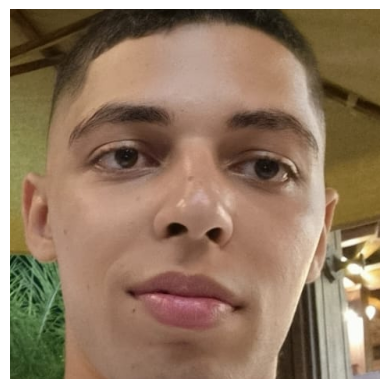

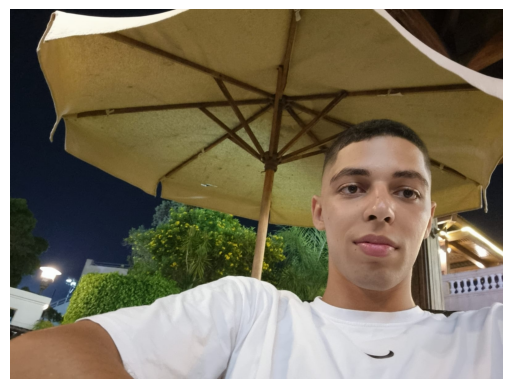

In [3]:

img_path = r'/content/me.jpg' # Assuming 'me.jpg' was uploaded
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Detect and crop the face
cropped_face = detect_and_crop_face(img)

plt.imshow(cropped_face)
plt.axis('off')
plt.show()
plt.imshow(img)
plt.axis('off')
plt.show()

In [44]:
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [45]:
def crop_face_resize(img, target_size=(224, 224)):
    # Detect and crop the face
    cropped_face = detect_and_crop_face(img)

    # Resize the cropped face to the target size
    resized_face = cv2.resize(cropped_face, target_size)

    return resized_face

In [36]:
import numpy as np

def get_inference(img_path, threshold=0.5, label_encoder=None):
    # Load and preprocess the image
    img = load_image(img_path)
    img = crop_face_resize(img)

    # Extract features using the feature extractor
    features = feature_extractor.predict(np.expand_dims(img, axis=0))

    # Get the predicted probabilities from the classifier
    probs = classifier.predict(features)

    # Find the index of the maximum probability (prediction)
    predicted_class = probs.argmax()

    # Get the confidence of the predicted class (probability of the prediction)
    confidence = probs[0, predicted_class]

    # Check if confidence is above the threshold
    if confidence >= threshold:
        # If label_encoder is provided, convert the class index to the class name
        if label_encoder:
            class_name = label_encoder.inverse_transform([predicted_class])[0]
            print(f"Prediction: {class_name}, Confidence: {confidence:.2f}")
        else:
            print(f"Prediction: Class {predicted_class}, Confidence: {confidence:.2f}")
    else:
        print("Unknown")


In [37]:
img_path = '/content/President_Barack_Obama.jpg'
print(get_inference(img_path,0.3,label_encoder))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction: barack obama, Confidence: 1.00
None


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

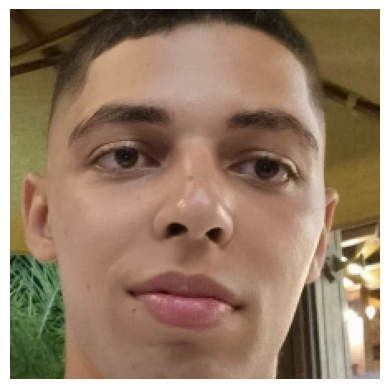

In [5]:
plt.imshow(crop_face_resize(img))
plt.axis('off')
plt

# Using Pytorch for inference

To predict unknown class we suggest utilise the pictures embeddings database then we will use cosine similarity to predict classes,if the cosine similarity to the closest is less than a threshold, the predicted class is "unknown"

In [46]:
# Define model
class ClassifierModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassifierModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.2)

        self.output_layer = nn.Linear(256, output_dim)

    def forward(self, x, return_embeddings=False):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        if return_embeddings:
            return x, torch.softmax(self.output_layer(x), dim=1)
        else:
            return torch.softmax(self.output_layer(x), dim=1)


load the KNN model and the label encoder

In [ ]:
import pickle
from sklearn.neighbors import NearestNeighbors

# Load the KNN model
with open('/content/drive/MyDrive/knn_model.pkl', 'rb') as f:
    knn = pickle.load(f)

# Load the labels
with open('/content/drive/MyDrive/knn_labels.pkl', 'rb') as f:
    knn_labels = pickle.load(f)

# Load the label encoder
with open('/content/drive/MyDrive/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

In [ ]:
model = ClassifierModel(input_dim=embeddings.shape[1], output_dim=y_one_hot.shape[1])
model.load_state_dict(torch.load('/content/drive/MyDrive/pytorch_face_recognition_model.pth'))

In [56]:
img = load_image('/content/me.jpg')
img = crop_face_resize(img)
img = feature_extractor.predict(np.expand_dims(img, axis=0))
model.eval()
with torch.no_grad():
  new_embedding, _ = model(torch.Tensor(img), return_embeddings=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [57]:
closest_class, similarity = predict_class(knn, labels, new_embedding)
if closest_class == "Unknown":
    print("Unknown")
else:
    print(f"The closest class is {label_encoder.inverse_transform([closest_class])[0]} with a similarity of {similarity}")



Unknown


In [58]:
img = load_image('/content/President_Barack_Obama.jpg')
img = crop_face_resize(img)
img = feature_extractor.predict(np.expand_dims(img, axis=0))
model.eval()
with torch.no_grad():
  new_embedding, _ = model(torch.Tensor(img), return_embeddings=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step


In [59]:
closest_class, similarity = predict_class(knn, labels, new_embedding)
if closest_class == "Unknown":
    print("Unknown")
else:
    print(f"The closest class is {label_encoder.inverse_transform([closest_class])[0]} with a similarity of {similarity}")


The closest class is barack obama with a similarity of 0.8662412762641907
